In [1]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [244]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [9]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Table of Content A/B Test Analysis

**Jennifer Wang, Staff Data Scientist, Wikimedia Foundation**

**July 2022**

[Analysis TICKET](https://phabricator.wikimedia.org/T309682)   
[AB test disabled on 2022-06-16](https://phabricator.wikimedia.org/T309683)

# Table of Contents
1. [Introduction](#Introduction)
2. [Purpose](#Purpose)
3. [Methodology](#Methodology)
4. [Data exploration](#Data-exploration)
5. [Data analysis](#Data-analysis)  
    5.1 [Clicks on ToC](#Clicks-on-ToC)  
    5.2 [Scrolls back to ToC](#Scrolls-to-ToC)  
    5.3 [Reading time](#Reading-time)


# Introduction
As a part of the [Desktop Improvements project](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements), The Wikimedia Foundation's [Web team](https://www.mediawiki.org/wiki/Readers/Web/Team)  is introducing a new Table of Contents (ToC). The goal is to make it easier for readers and editors to gain context and navigate throughout the page without needing to scroll to the top. Please find more information on this change and other feature deployments on the [Table of contents project page](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements/Features/Table_of_contents).

An AB test was performed on the early adopter wikis between May 26, 2022 and June 15, 2022 for both logged-in users and anonymous users. This report details the analysis and results for the deployment of the new table of contents on both user groups. 

## Old feature


<img src="Figures/old.png" width="800" height="600" align="center"/>

## New feature

<img src="Figures/new.png" width="800" height="600" align="center"/>

# Purpose

The primary goal of the AB Test was to test the hypothesis that 
1) the group with the new ToC will get more clicks as it is easier for user to reach
2) the group with the new ToC will get less scrolls back to ToC as it is easier for user to navigate 

As part of this analysis, we were also curious about how the new ToC affects the time readers spent on a page.


# Methodology

The AB test was run on a per wiki basis on both logged-in users and anonymous users. The sessions included in the test were randomly assigned to either the control (old ToC) or treatment (new ToC) based on their landing page id.

We compared the total numbers of clicks, the total numbers of scrolls, the average reading time (second/kilobyte) between control and treatment groups. We also reviewed the difference in percentage between the treatment group and the control group. The logged-in user group and anonymous user group are analyzed separately. 

We also ran Hierarchical Generalized Linear Modeling on session based data to determine if the difference is statistically significant.

# Data exploration

## Check total enrollment  

June 9, 2022


In [7]:
query <- "
select wiki, TO_DATE(meta.dt) AS date_time,`group` AS test_group, count(1) AS pv,
count(distinct web_session_id) AS sessions
FROM event.mediawiki_web_ab_test_enrollment
WHERE year=2022 AND month IN (4, 5,6)
AND experiment_name='skin-vector-toc-experiment'
GROUP BY wiki, TO_DATE(meta.dt),`group`
ORDER BY wiki, date_time, `group`
LIMIT 100000
"

In [8]:
df <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [13]:
df$date_time <- as.Date(df$date_time)

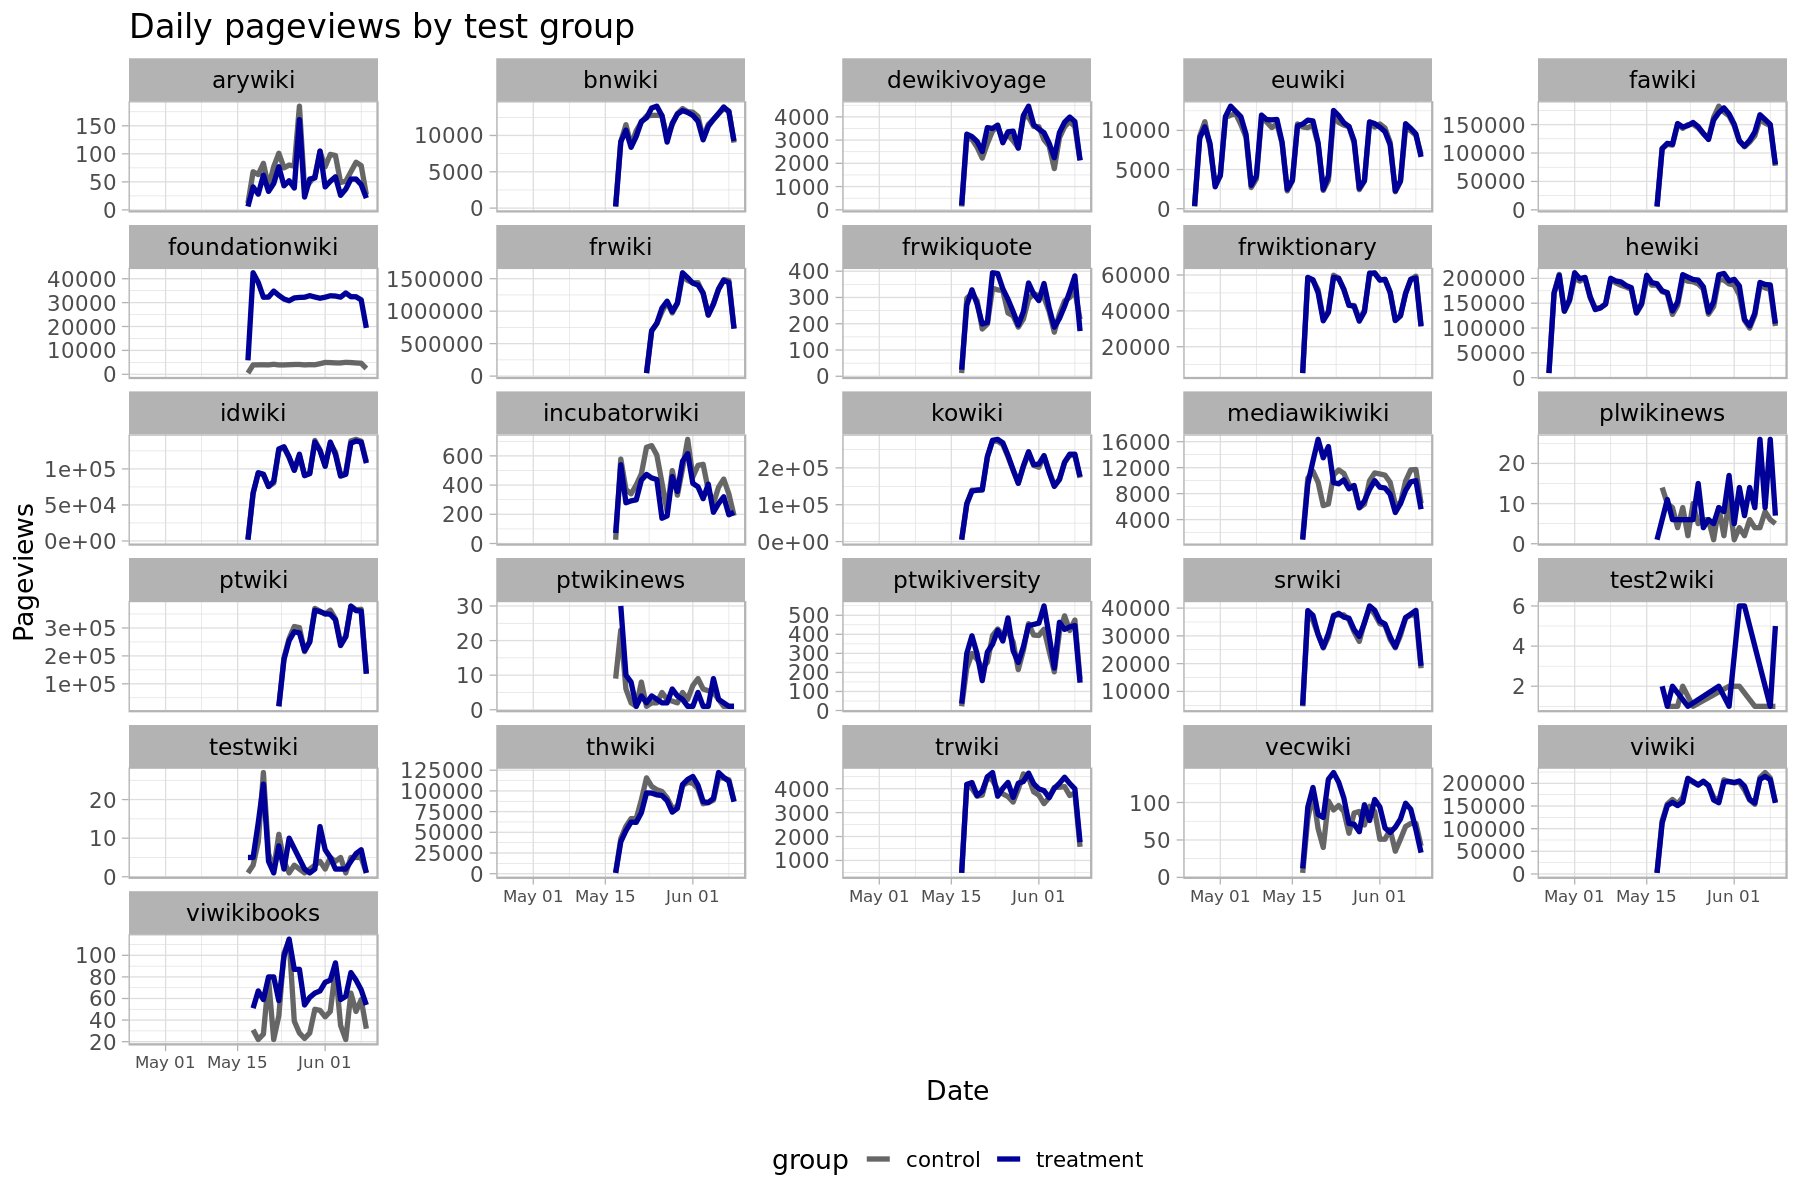

In [16]:
g_pv <- ggplot(data=df, 
                                mapping=aes(x=date_time, y=pv, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily pageviews by test group',
     x = 'Date',
     y = 'Pageviews') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_pv

In [15]:
head(df_pv)

,wiki,domain,test_group,total_pv
,<chr>,<chr>,<chr>,<int>
1,arywiki,ary.wikipedia.org,control,1715
2,arywiki,ary.wikipedia.org,treatment,1101
3,arywiki,ary.wikipedia.shisu.cf,control,1
4,bnwiki,bn.wikipedia.ahau.cf,control,3
5,bnwiki,bn.wikipedia.ahau.cf,treatment,2
6,bnwiki,bn.wikipedia.ahmu.cf,control,1


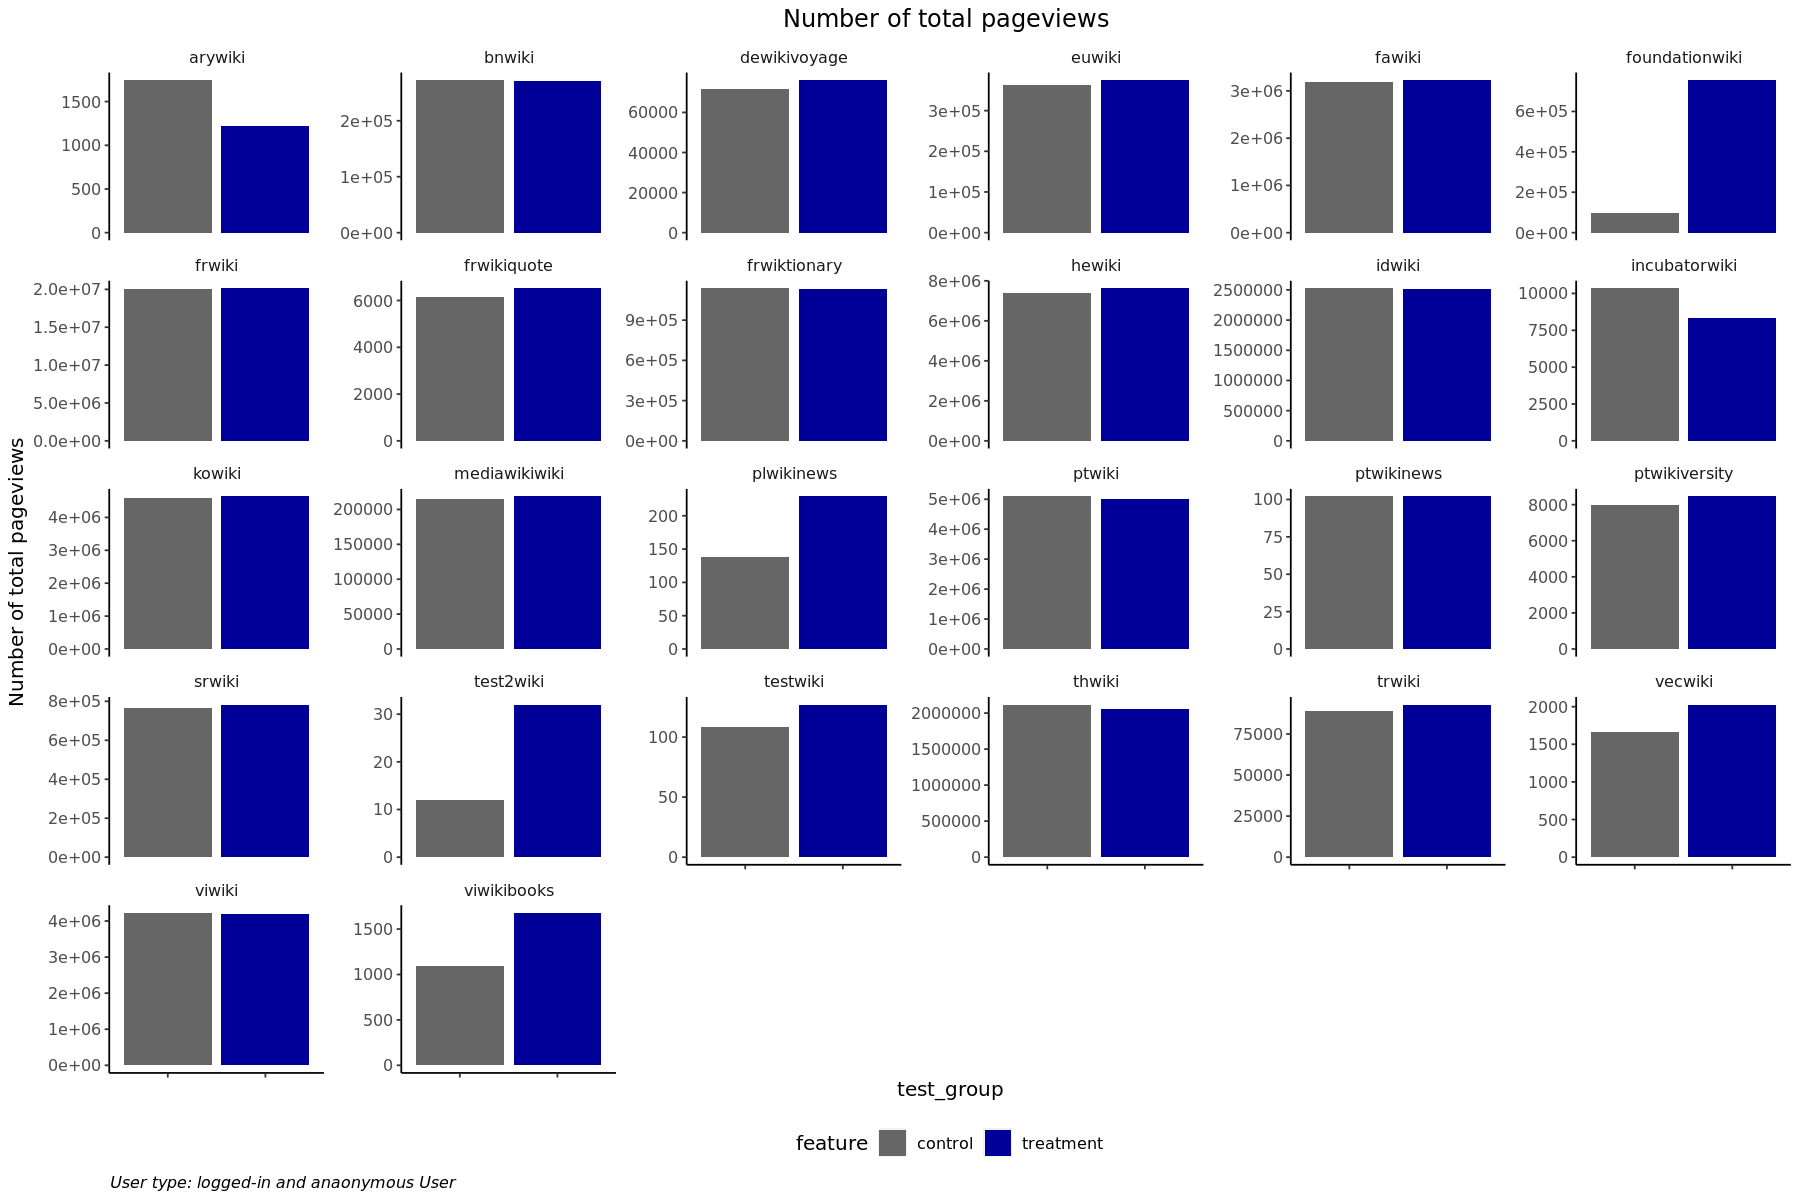

In [18]:
barchart_pv_overall  <- df  %>%
        group_by(wiki, test_group) %>% 
        summarize(total_pv=sum(pv), .groups='drop') %>%
        ggplot(aes(x = test_group, y= total_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total pageviews" ,
             title = "Number of total pageviews " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_pv_overall

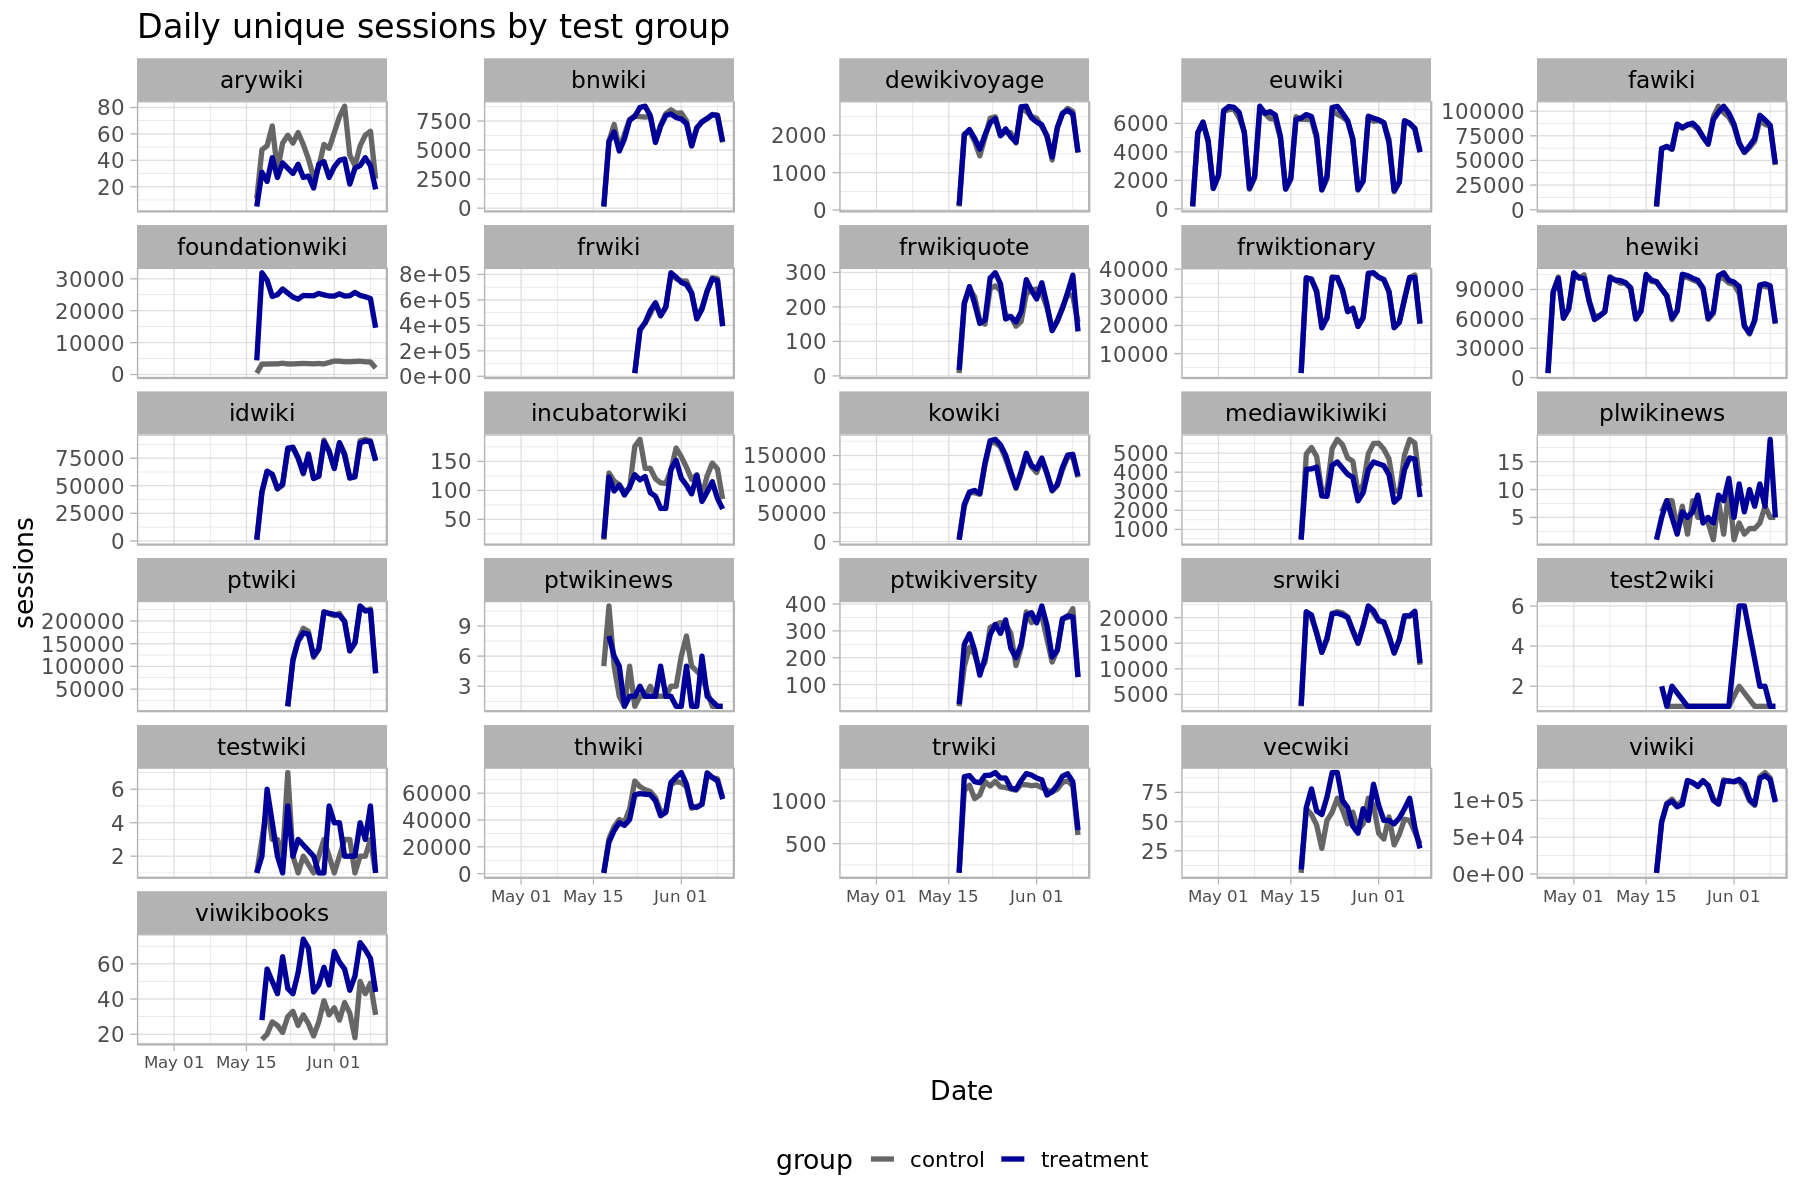

In [20]:
g_s <- ggplot(data=df, 
                                mapping=aes(x=date_time, y=sessions, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily unique sessions by test group',
     x = 'Date',
     y = 'sessions') + 
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_s

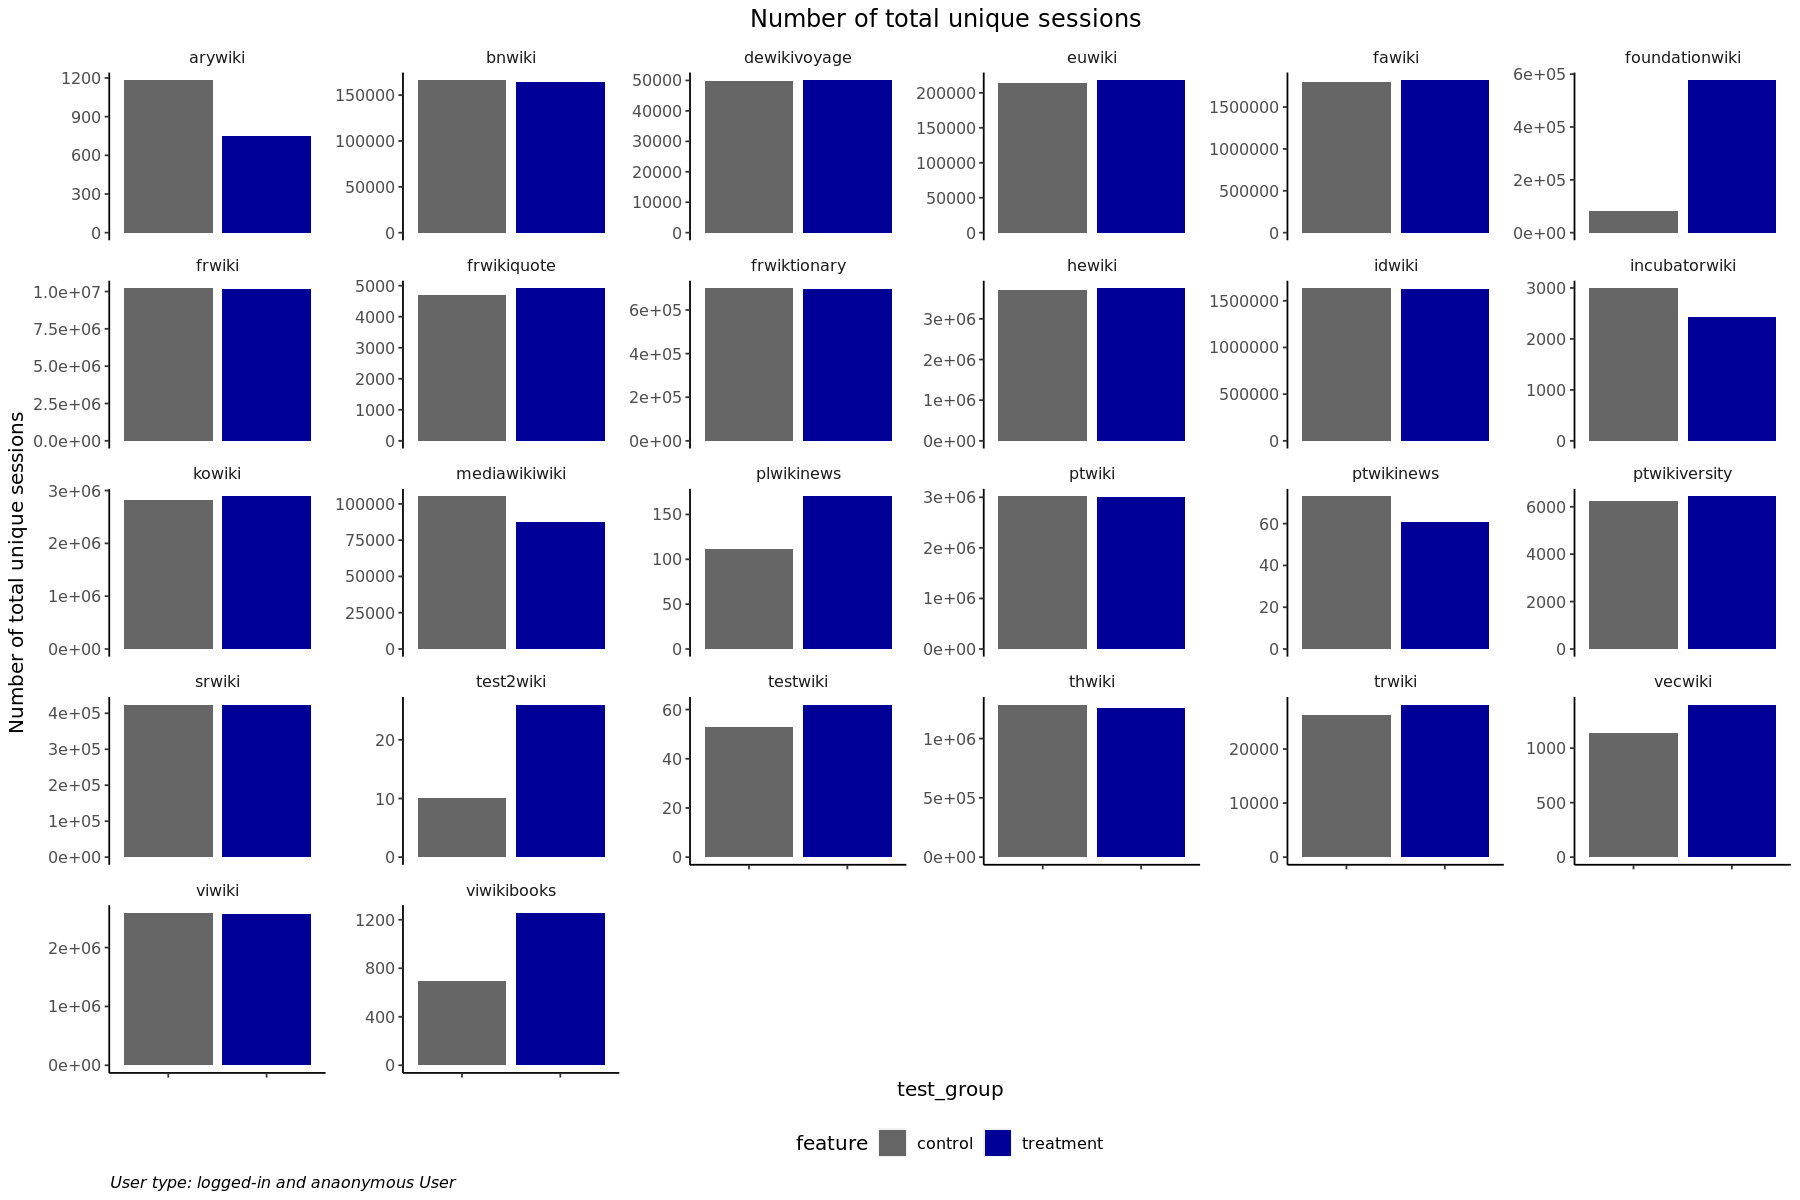

In [21]:
barchart_sessions_overall  <- df  %>%
        group_by(wiki, test_group) %>% 
        summarize(total_sessions=sum(sessions), .groups='drop') %>%
        ggplot(aes(x = test_group, y= total_sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total unique sessions" ,
             title = "Number of total unique sessions " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall

__Note:__  


5 wikis with low traffic:  plwikinews, ptwikinews, vecwiki, arywiki, viwikibook  
Foundationwiki has low traffic in the control group.


## Check sessions are assigned in both groups

In [24]:
query_check_duplicate <- "
WITH t_duplicate AS
(SELECT  web_session_id, wiki, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month IN (5,6)
GROUP BY  web_session_id, wiki
HAVING groups>1
)
SELECT wiki, count(web_session_id) AS dup_sessions
FROM t_duplicate
GROUP BY wiki
"

In [27]:
df_duplicate <- wmfdata::query_hive(query_check_duplicate)

Don't forget to authenticate with Kerberos using kinit



In [28]:
df_duplicate

wiki,dup_sessions
<chr>,<int>
arywiki,66
bnwiki,43730
dewikivoyage,5352
euwiki,56140
fawiki,662118
foundationwiki,8265
frwiki,3546160
frwikiquote,605
frwiktionary,131209


__Note:__


All sessions assigned to both treatment group and control group need to be excluded in analysis

## Check bucketing of non-duplicated sessions

In [4]:
query_non_duplicate <- "
WITH t_ab_no_duplicate AS
(SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month IN (5,6)
GROUP BY  web_session_id, wiki,  meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
)
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN t_ab_no_duplicate AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  and t1.year=2022 and t1.month IN (5,6) 
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
" 

In [5]:
df_ab <- wmfdata::query_hive(query_non_duplicate)

Don't forget to authenticate with Kerberos using kinit



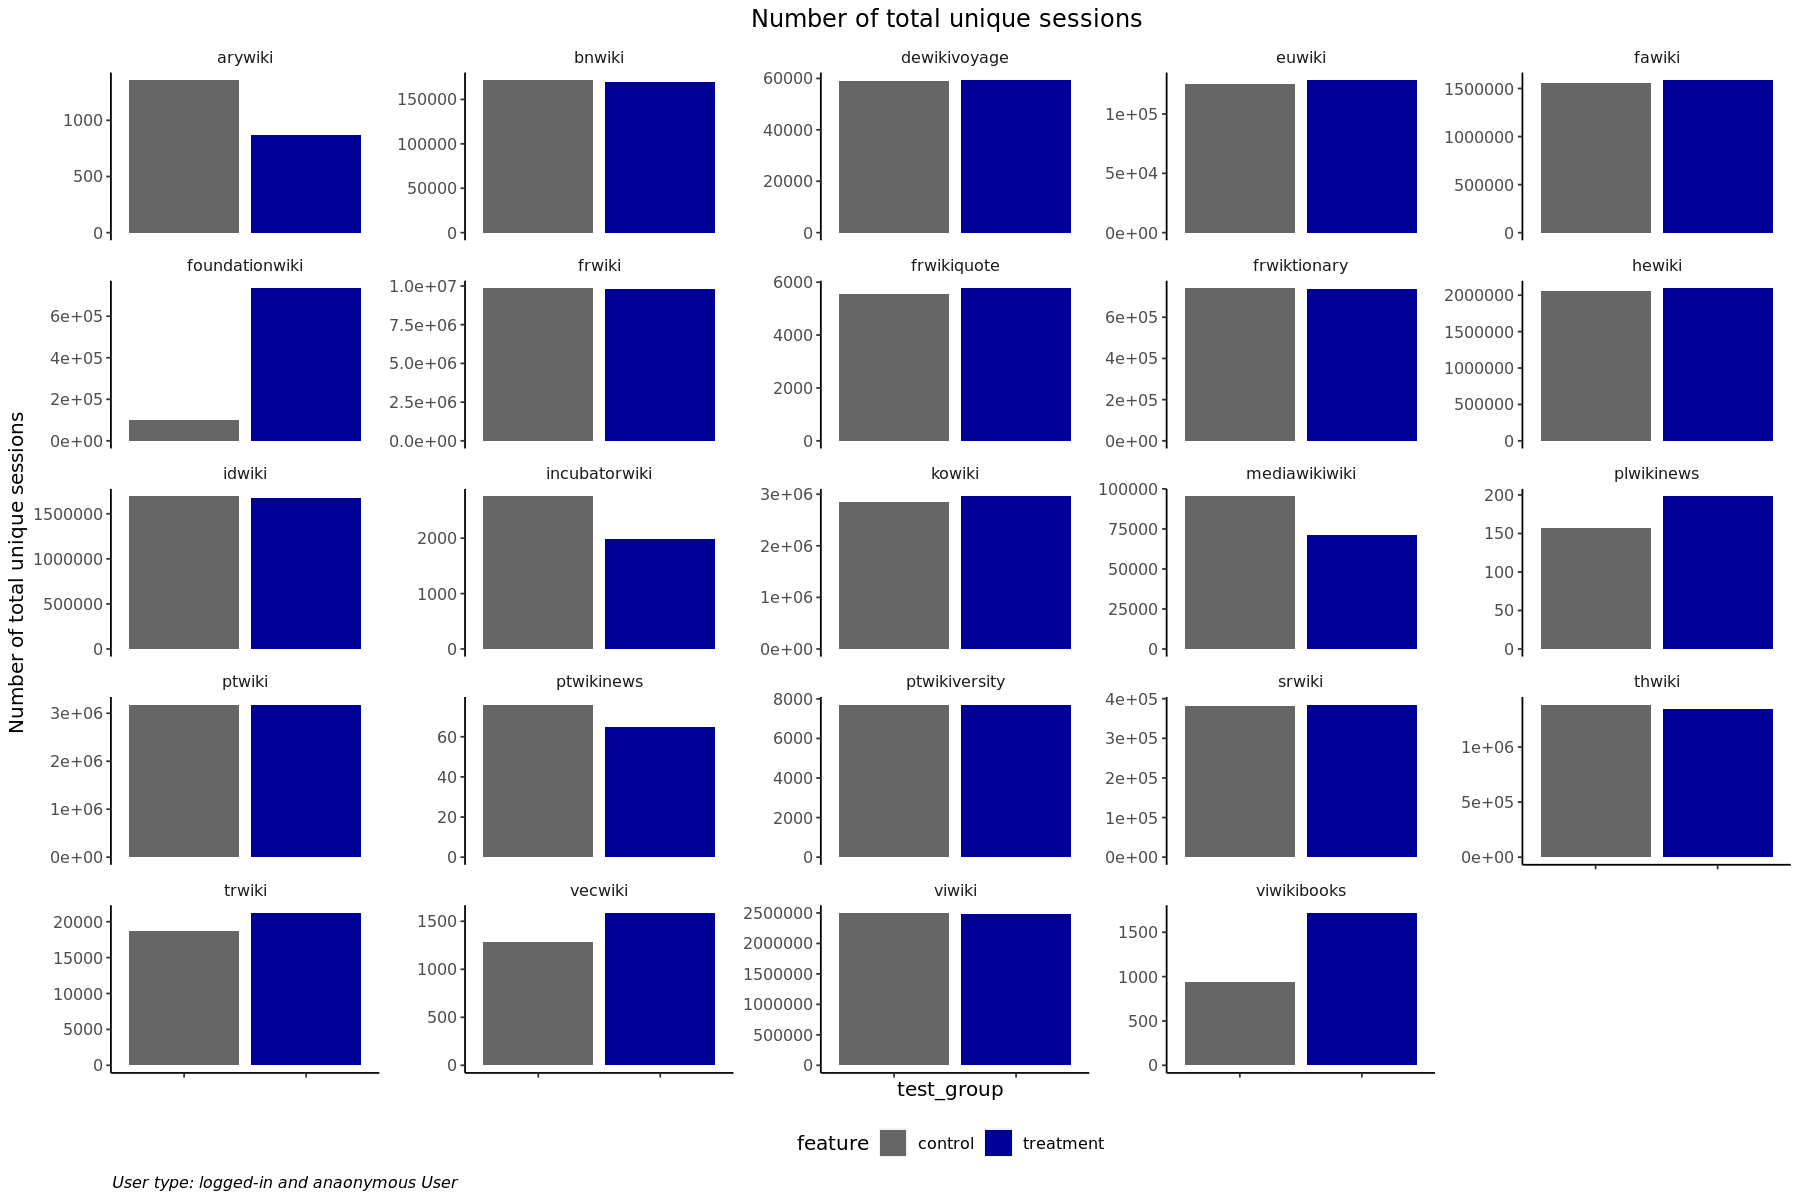

In [7]:
barchart_sessions_overall  <- df_ab  %>%
        group_by(wiki, test_group) %>% 
        summarize(sessions=n_distinct(web_session_id), .groups='drop') %>%
        ggplot(aes(x = test_group, y= sessions, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total unique sessions" ,
             title = "Number of total unique sessions " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall

__Note:__  


8 wikis have unbalanced distribution on unique session: arywiki, foundationwiki, incubatorwiki, mediawiki, 
plwikinews, ptwikinews, vecwiki, viwikibook  .  


In [11]:
query_non_duplicate_pv <- "
WITH t_ab_no_duplicate AS
(SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  and year=2022 and month IN (5,6)
GROUP BY  web_session_id, wiki,  meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
)
SELECT 
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 COUNT(1) AS total_pv 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN t_ab_no_duplicate AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  and t1.year=2022 and t1.month IN (5,6) 
GROUP BY t1.wiki,t1.meta.domain, t1.`group`
" 

In [12]:
df_pv <- wmfdata::query_hive(query_non_duplicate_pv)

Don't forget to authenticate with Kerberos using kinit



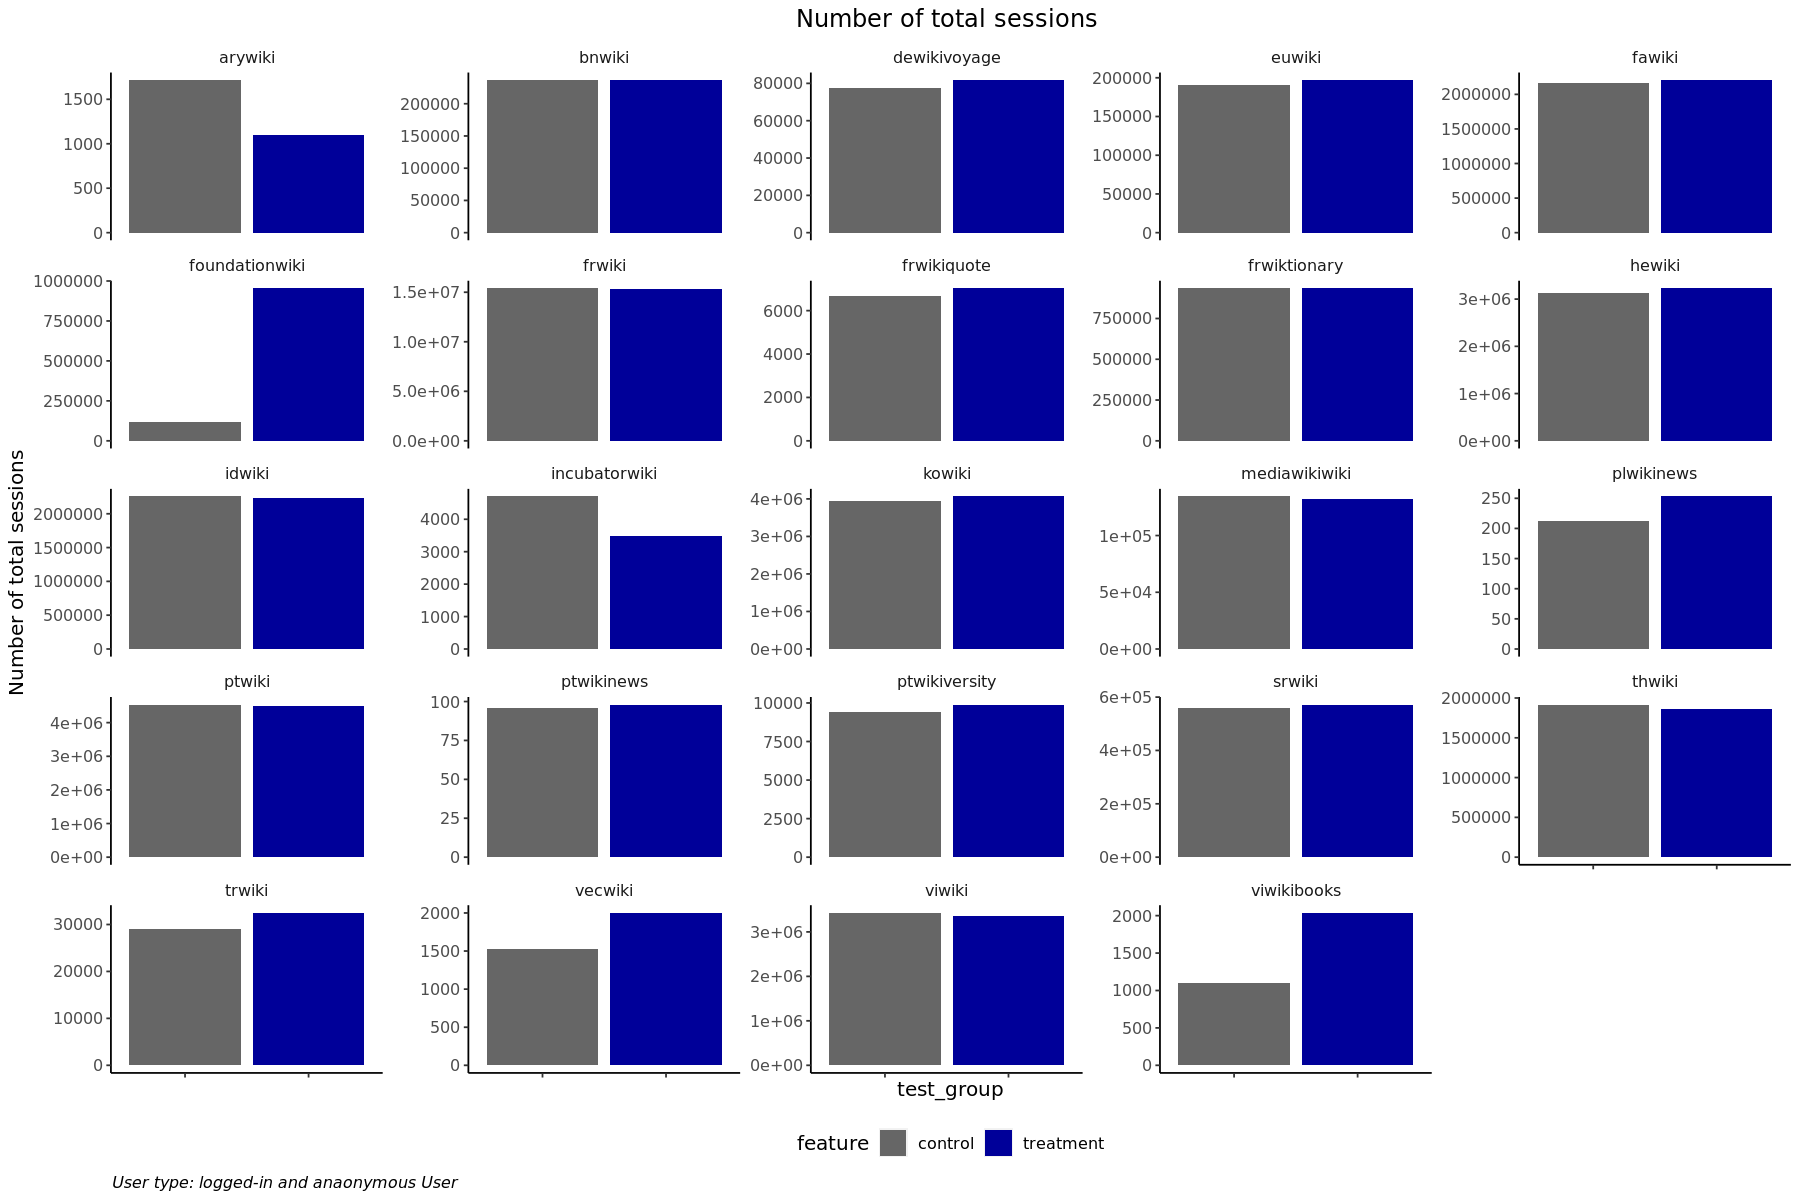

In [13]:
barchart_sessions_overall_2  <- df_pv  %>%
        ggplot(aes(x = test_group, y= total_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total sessions" ,
             title = "Number of total sessions " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall_2

__Note:__. 


5 wikis have unbalanced distribution on total pageviews: arywiki, foundationwiki, incubatorwiki,  
 vecwiki, viwikibook  .  


# Data analysis


## Clicks on ToC
__Test question: Is the new table of contents is used more frequently than the previous table of contents__


In [126]:
query_click <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)
-- clicks from ab test group
SELECT CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) AS event_date, 
wiki, event.isanon,  t4.test_group, count(1) AS clicks
FROM event.DesktopWebUIActionsTracking AS t3
INNER JOIN t_ab AS t4 
ON  t3.wiki=t4.wiki AND t3.event.token = t4.web_session_id
WHERE t3.wiki IN ('bnwiki', 'fawiki', 'foundationwiki',
'hewiki', 'ptwikinews', 'ptwikiversity', 'srwiki',
'thwiki', 'vecwiki', 'viwiki', 'viwikibooks', 'dewikivoyage',
'euwiki', 'kowiki', 'plwikinews', 'trwiki', 'arywiki',
'frwiki', 'frwikiquote', 'frwiktionary', 'incubatorwiki', 'ptwiki'
) 
AND t3.year=2022 and t3.month IN (5,6)
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND t4.session_dt <= t3.meta.dt
AND event.name = 'ui.toc'
AND event.action='click' AND event.skinversion=2 
GROUP BY t3.year, t3.month,t3.day, t3.wiki, event.isanon, t4.test_group
"

In [127]:
df_clicks <- wmfdata::query_hive(query_click)

Don't forget to authenticate with Kerberos using kinit



In [128]:
df_clicks$event_date <- as.Date(df_clicks$event_date)

In [158]:
df_clicks

event_date,wiki,isanon,test_group,clicks
<date>,<chr>,<chr>,<chr>,<int>
2022-05-26,bnwiki,false,control,3
2022-05-26,bnwiki,true,control,88
2022-05-26,bnwiki,true,treatment,2
2022-05-26,dewikivoyage,false,control,5
2022-05-26,dewikivoyage,true,control,57
2022-05-26,euwiki,false,control,3
2022-05-26,euwiki,true,control,86
2022-05-26,fawiki,false,control,38
2022-05-26,fawiki,true,control,471


### Logged-in user

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



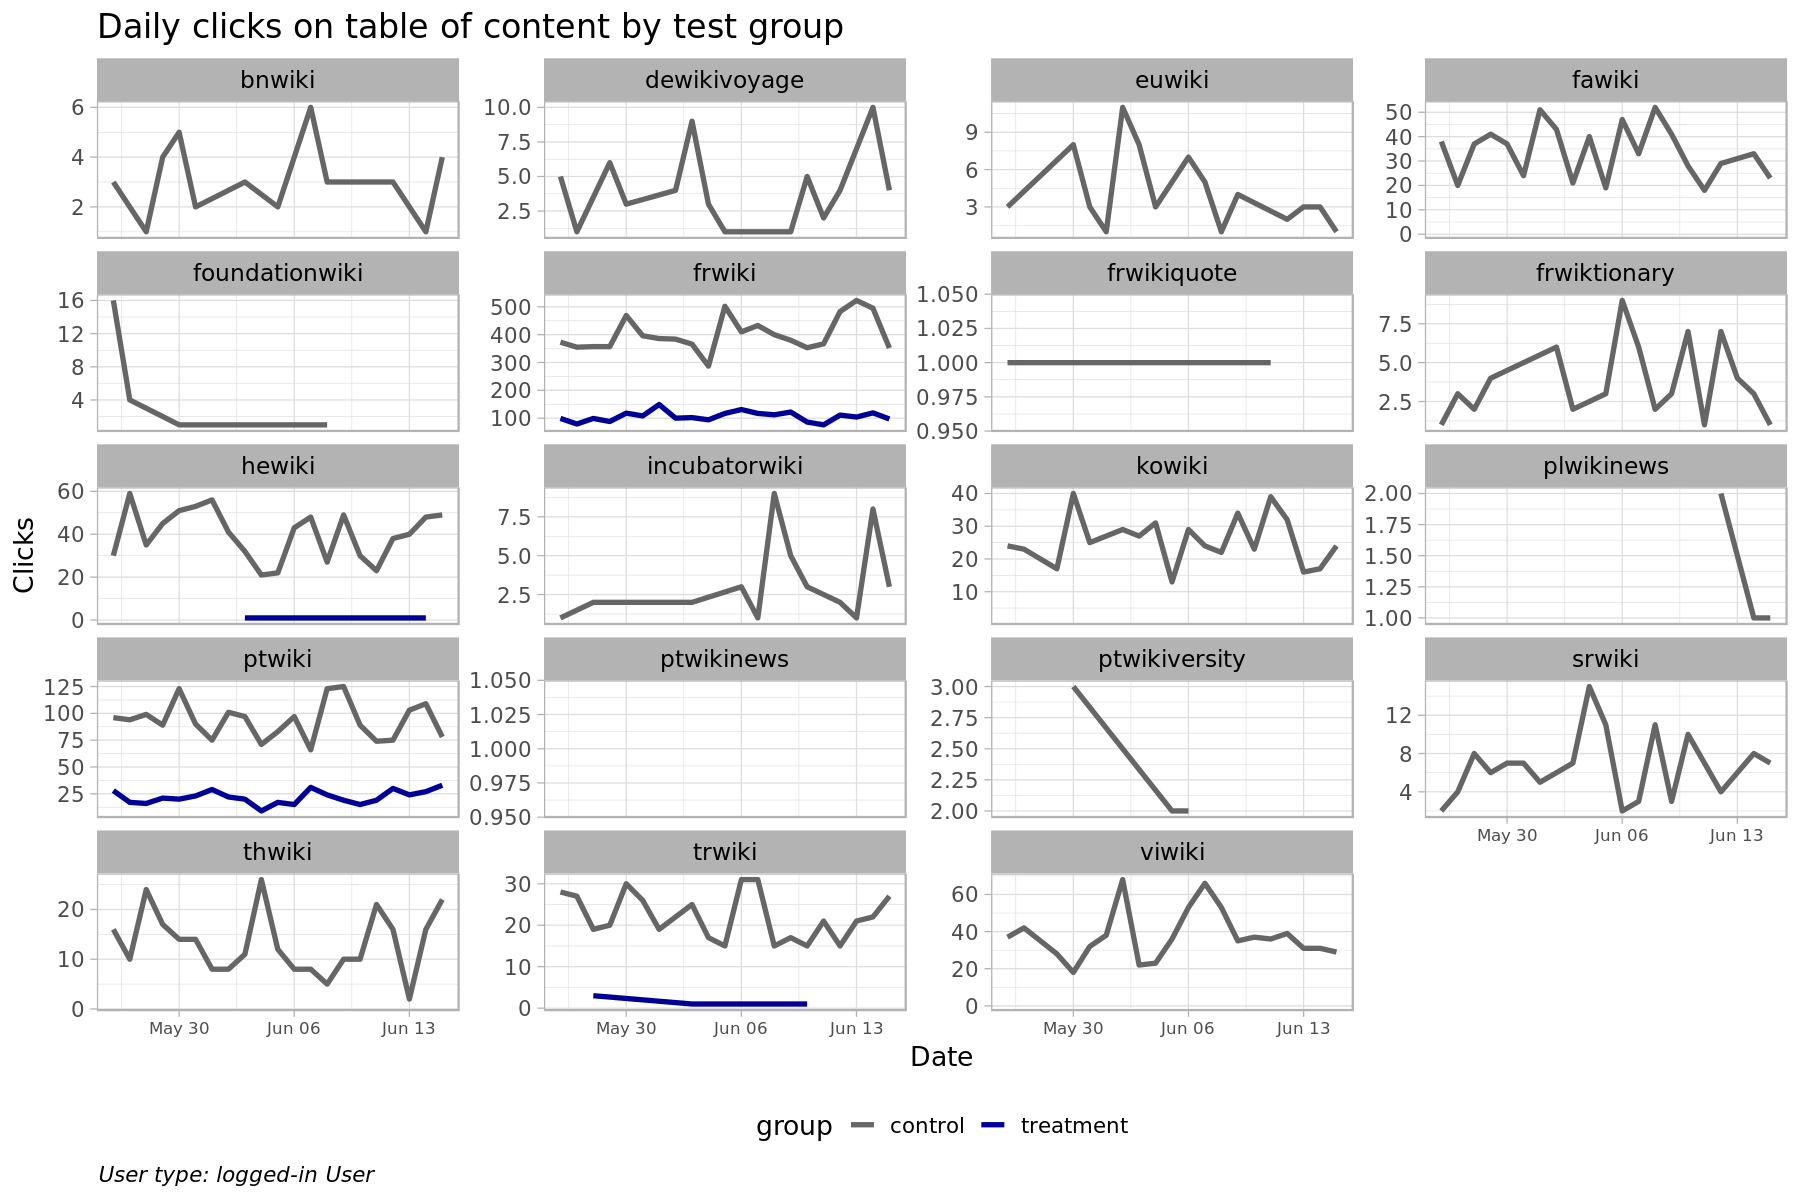

In [130]:
g_click_loggedin <-  df_clicks %>%
filter(isanon=='false') %>% 
ggplot(mapping=aes(x=event_date, y=clicks, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily clicks on table of content by test group',
     x = 'Date',
     y = 'Clicks',
    caption = "User type: logged-in User" ) +
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     plot.caption = element_text(hjust = 0, face= "italic"),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_click_loggedin 

In [161]:
df_c_loggedin <- df_clicks  %>%
        filter(isanon=='false' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' & wiki!='vecwiki'& wiki!='viwikibook') %>%
        group_by(wiki, test_group ) %>%
        summarize(total_clicks=sum(clicks), .groups='drop')

In [162]:
df_c_loggedin

wiki,test_group,total_clicks
<chr>,<chr>,<int>
bnwiki,control,51
dewikivoyage,control,60
euwiki,control,68
fawiki,control,706
fawiki,treatment,1
frwiki,control,8428
frwiki,treatment,2228
frwikiquote,control,5
frwiktionary,control,64


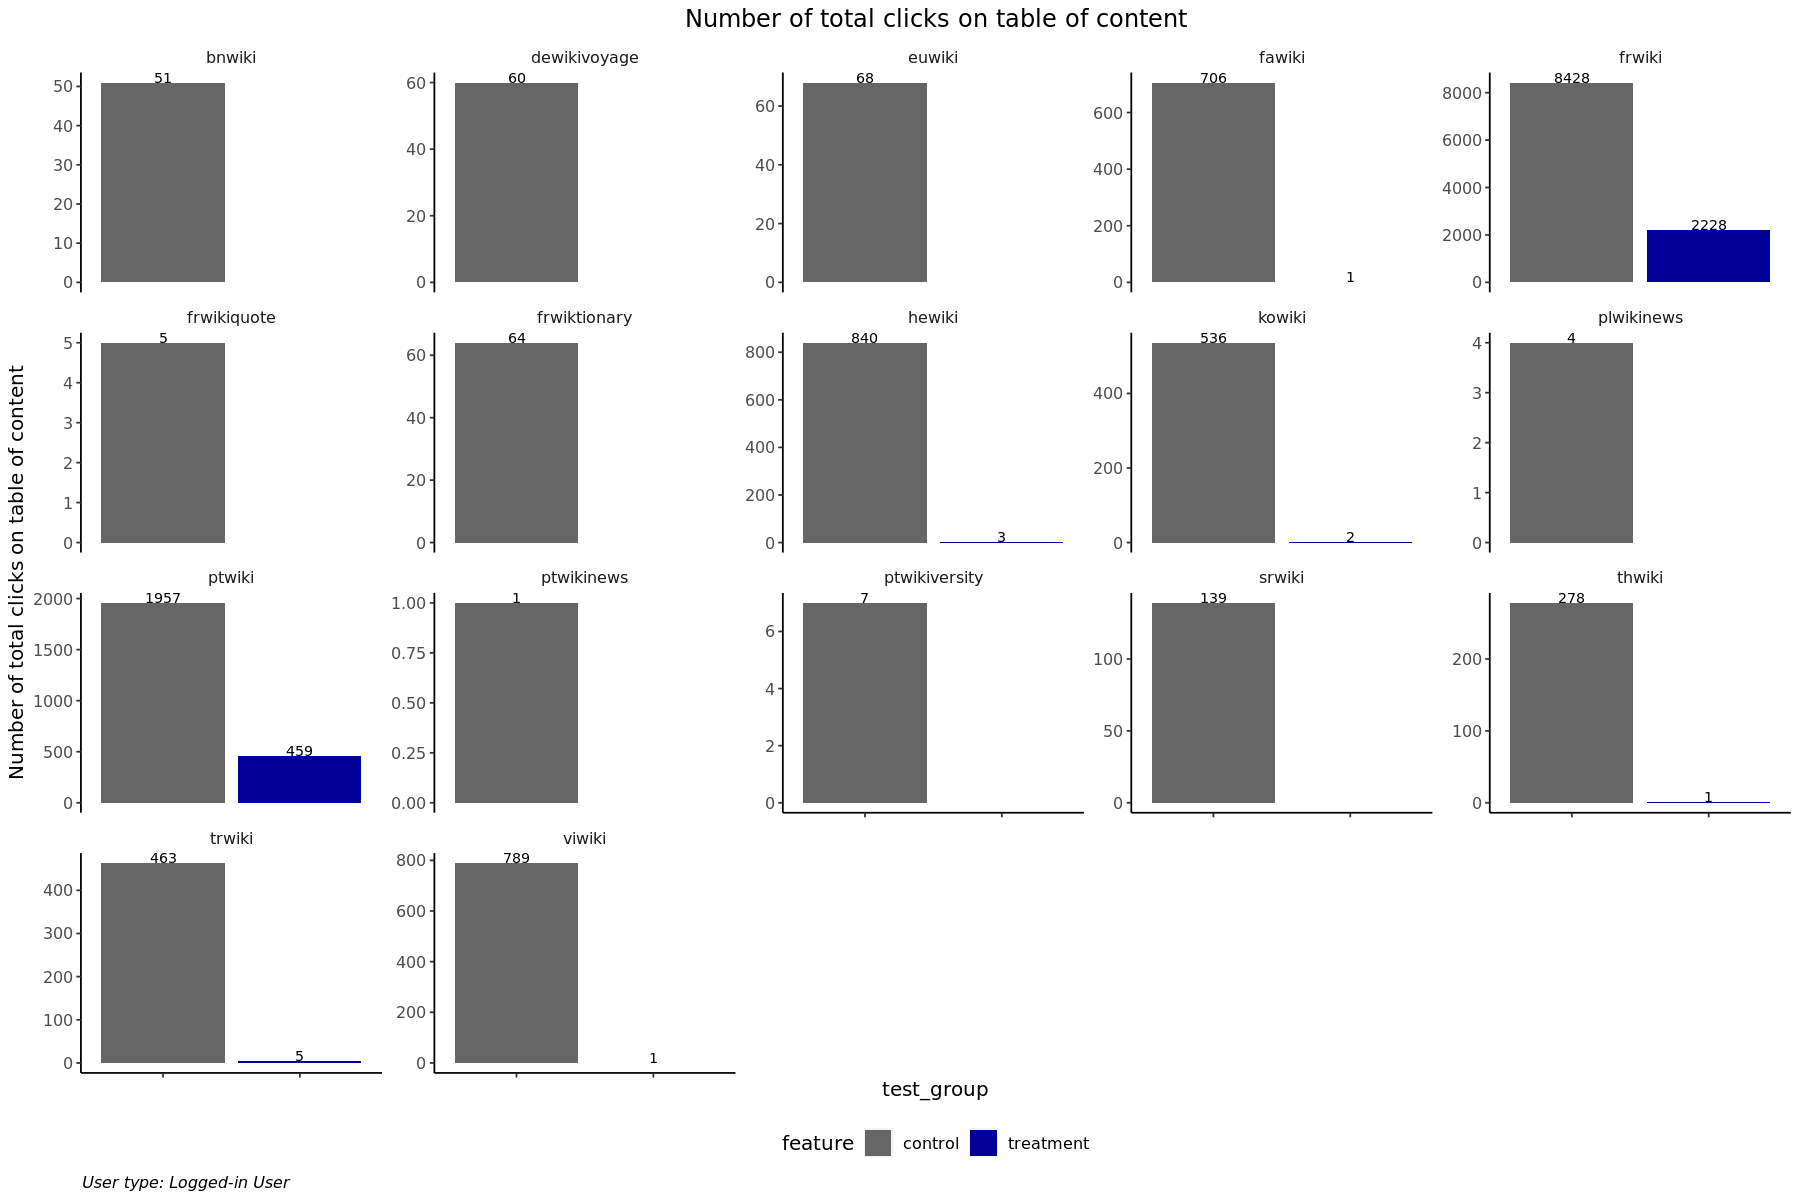

In [163]:
barchart_clicks_loggedin  <- df_c_loggedin %>%
        ggplot(aes(x = test_group, y= total_clicks, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_clicks)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total clicks on table of content" ,
             title = "Number of total clicks on table of content" ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_clicks_loggedin

### Anonymous user

In [164]:
df_c_anon <- df_clicks  %>%
        filter(isanon=='true' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' & wiki!='vecwiki'& wiki!='viwikibook') %>%
        group_by(wiki, test_group ) %>%
        summarize(total_clicks=sum(clicks), .groups='drop')
df_c_anon

wiki,test_group,total_clicks
<chr>,<chr>,<int>
bnwiki,control,2015
bnwiki,treatment,17
dewikivoyage,control,962
euwiki,control,1171
euwiki,treatment,1
fawiki,control,10181
fawiki,treatment,150
frwiki,control,270630
frwiki,treatment,48382


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



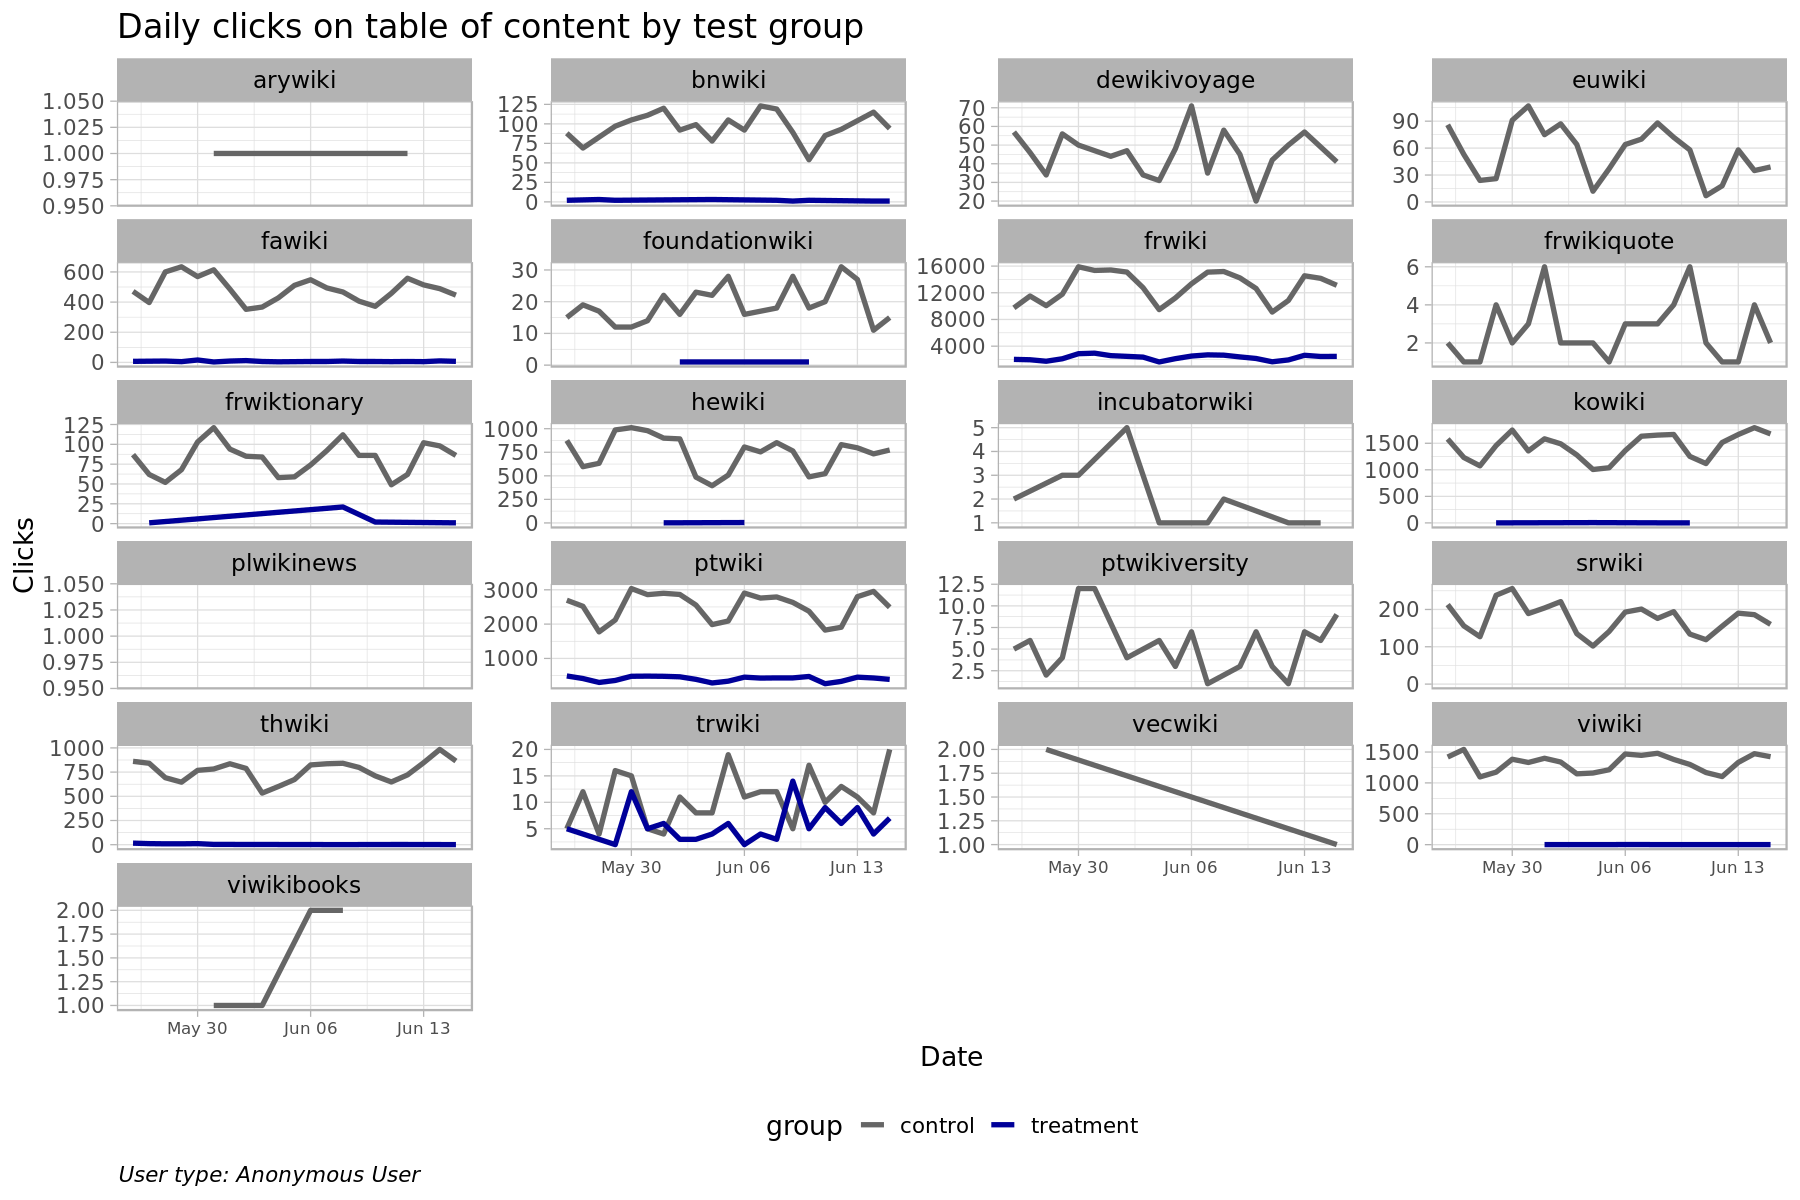

In [165]:
g_click_anon <-  df_clicks %>%
filter(isanon=='true') %>% 
ggplot(mapping=aes(x=event_date, y=clicks, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily clicks on table of content by test group',
     x = 'Date',
     y = 'Clicks',
    caption = "User type: Anonymous User" ) +
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     plot.caption = element_text(hjust = 0, face= "italic"),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_click_anon

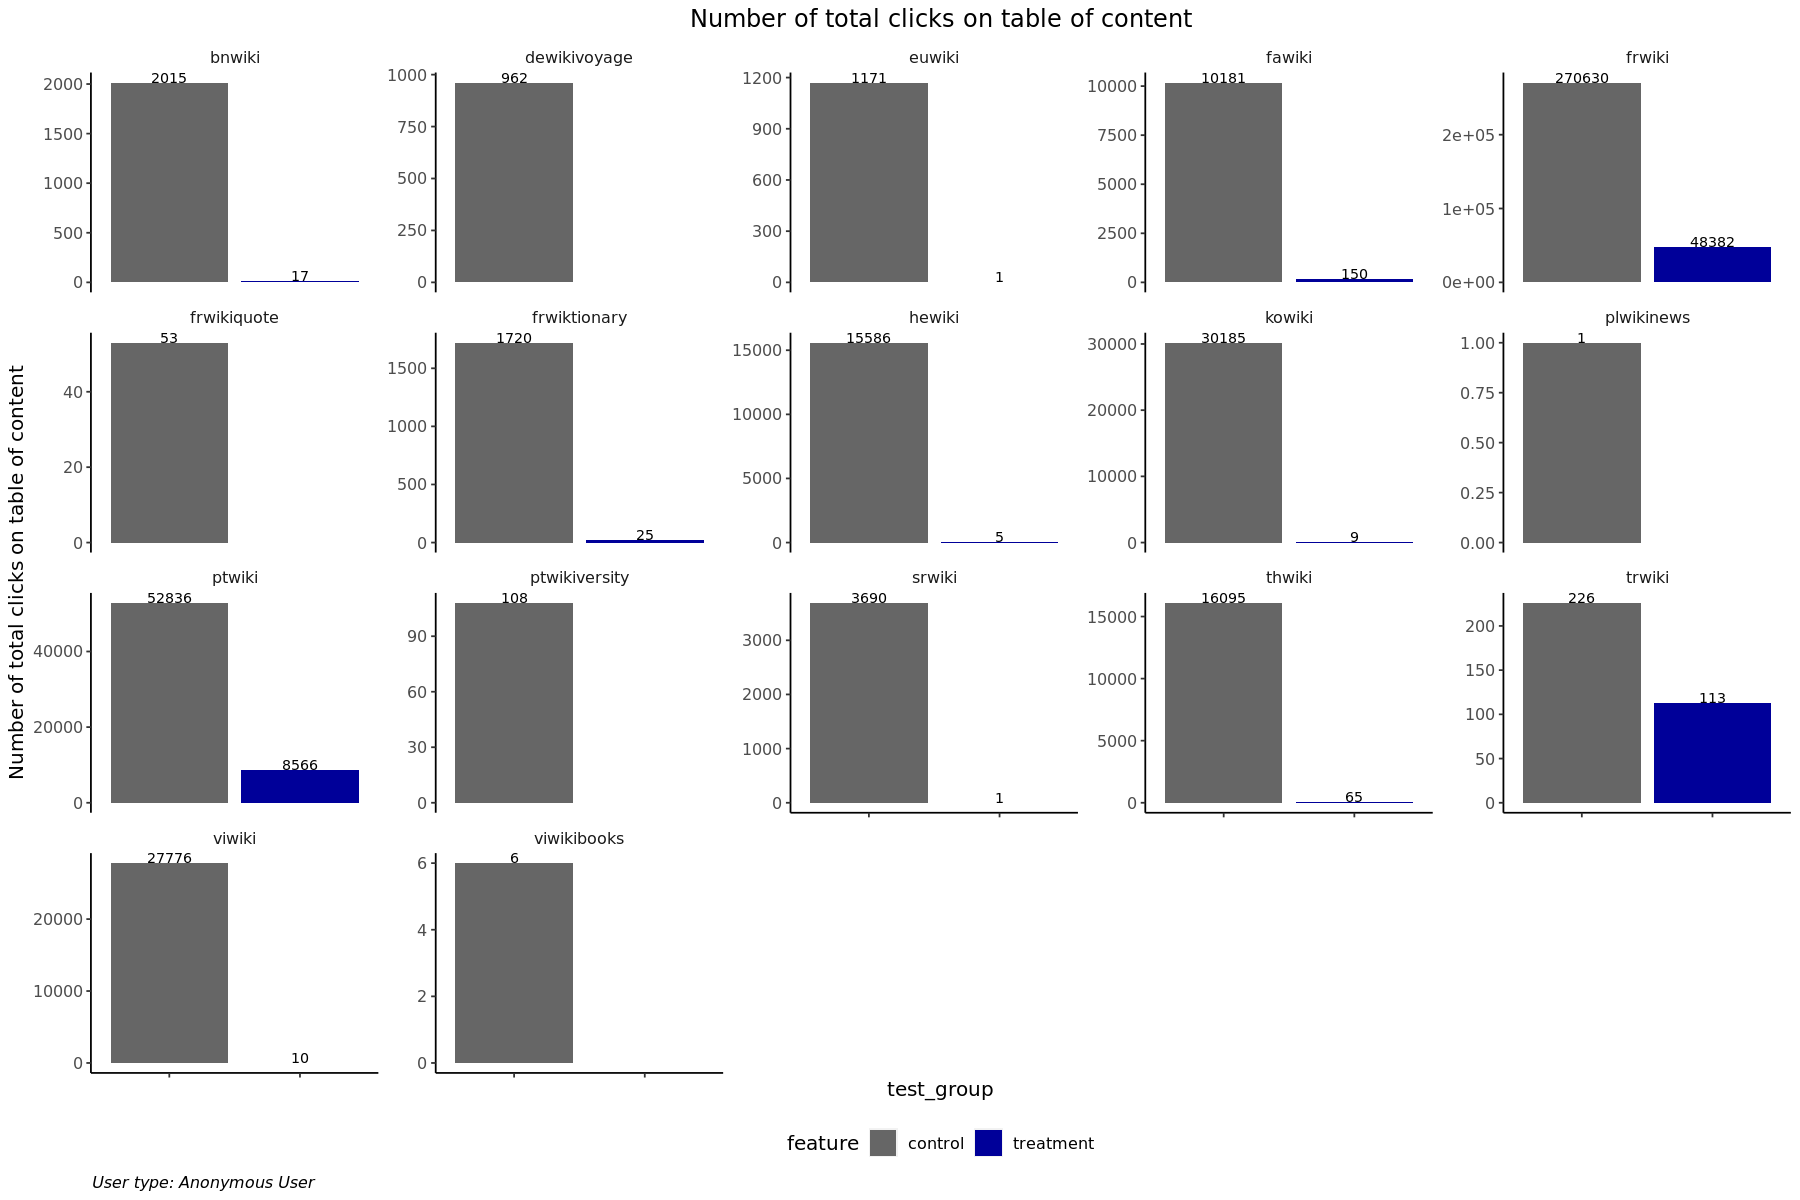

In [166]:
barchart_clicks_anon  <- df_c_anon %>%
        ggplot(aes(x = test_group, y= total_clicks, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_clicks)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total clicks on table of content" ,
             title = "Number of total clicks on table of content" ,
             caption = "User type: Anonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_clicks_anon

__Summary__  


The hypothesis that the new table of contents is used more frequently than the previous table of contents is NOT supported by data. Instead, The clicks on ToC in treatment group is much fewer than in control group for both logged-in users and anonymous users.

Need to discuss with PM. 

## Scrolls to ToC

Test question: Does the new table of contents reduce the need to scroll back to the top of the page


In [137]:
query_scroll <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022  
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)

--scrolls by session
SELECT  TO_DATE(t3.meta.dt) AS event_date,t_ab.wiki,   t_ab.test_group, t3.is_anon, t3.web_session_id, COUNT(1) AS scrolls 
FROM t_ab
LEFT JOIN event.mediawiki_web_ui_scroll AS t3 
ON t_ab.domain=t3.meta.domain AND t3.web_session_id = t_ab.web_session_id
AND t3.year=2022 AND month IN (5,6) 
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
WHERE t_ab.session_dt <= t3.meta.dt
AND t3.action='scroll-to-toc'
GROUP BY  TO_DATE(t3.meta.dt) , t_ab.wiki,   t_ab.test_group, t3.is_anon, t3.web_session_id

"


In [138]:
df_scrolls <- wmfdata::query_hive(query_scroll)

Don't forget to authenticate with Kerberos using kinit



In [140]:
df_scrolls$event_date <- as.Date(df_scrolls$event_date)

In [ ]:
write_csv(df_scrolls, "Data_out/scrolls.csv")

### Logged-in Users

In [167]:
df_s_loggedin <- df_scrolls  %>%
        filter(is_anon=='false' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' & wiki!='vecwiki'& wiki!='viwikibook') %>%
        group_by(wiki, test_group ) %>%
        summarize(total_scrolls=sum(scrolls), .groups='drop')

In [168]:
df_s_loggedin

wiki,test_group,total_scrolls
<chr>,<chr>,<int>
bnwiki,control,712
bnwiki,treatment,827
dewikivoyage,control,128
dewikivoyage,treatment,434
euwiki,control,893
euwiki,treatment,848
fawiki,control,5855
fawiki,treatment,5241
frwiki,control,37162


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



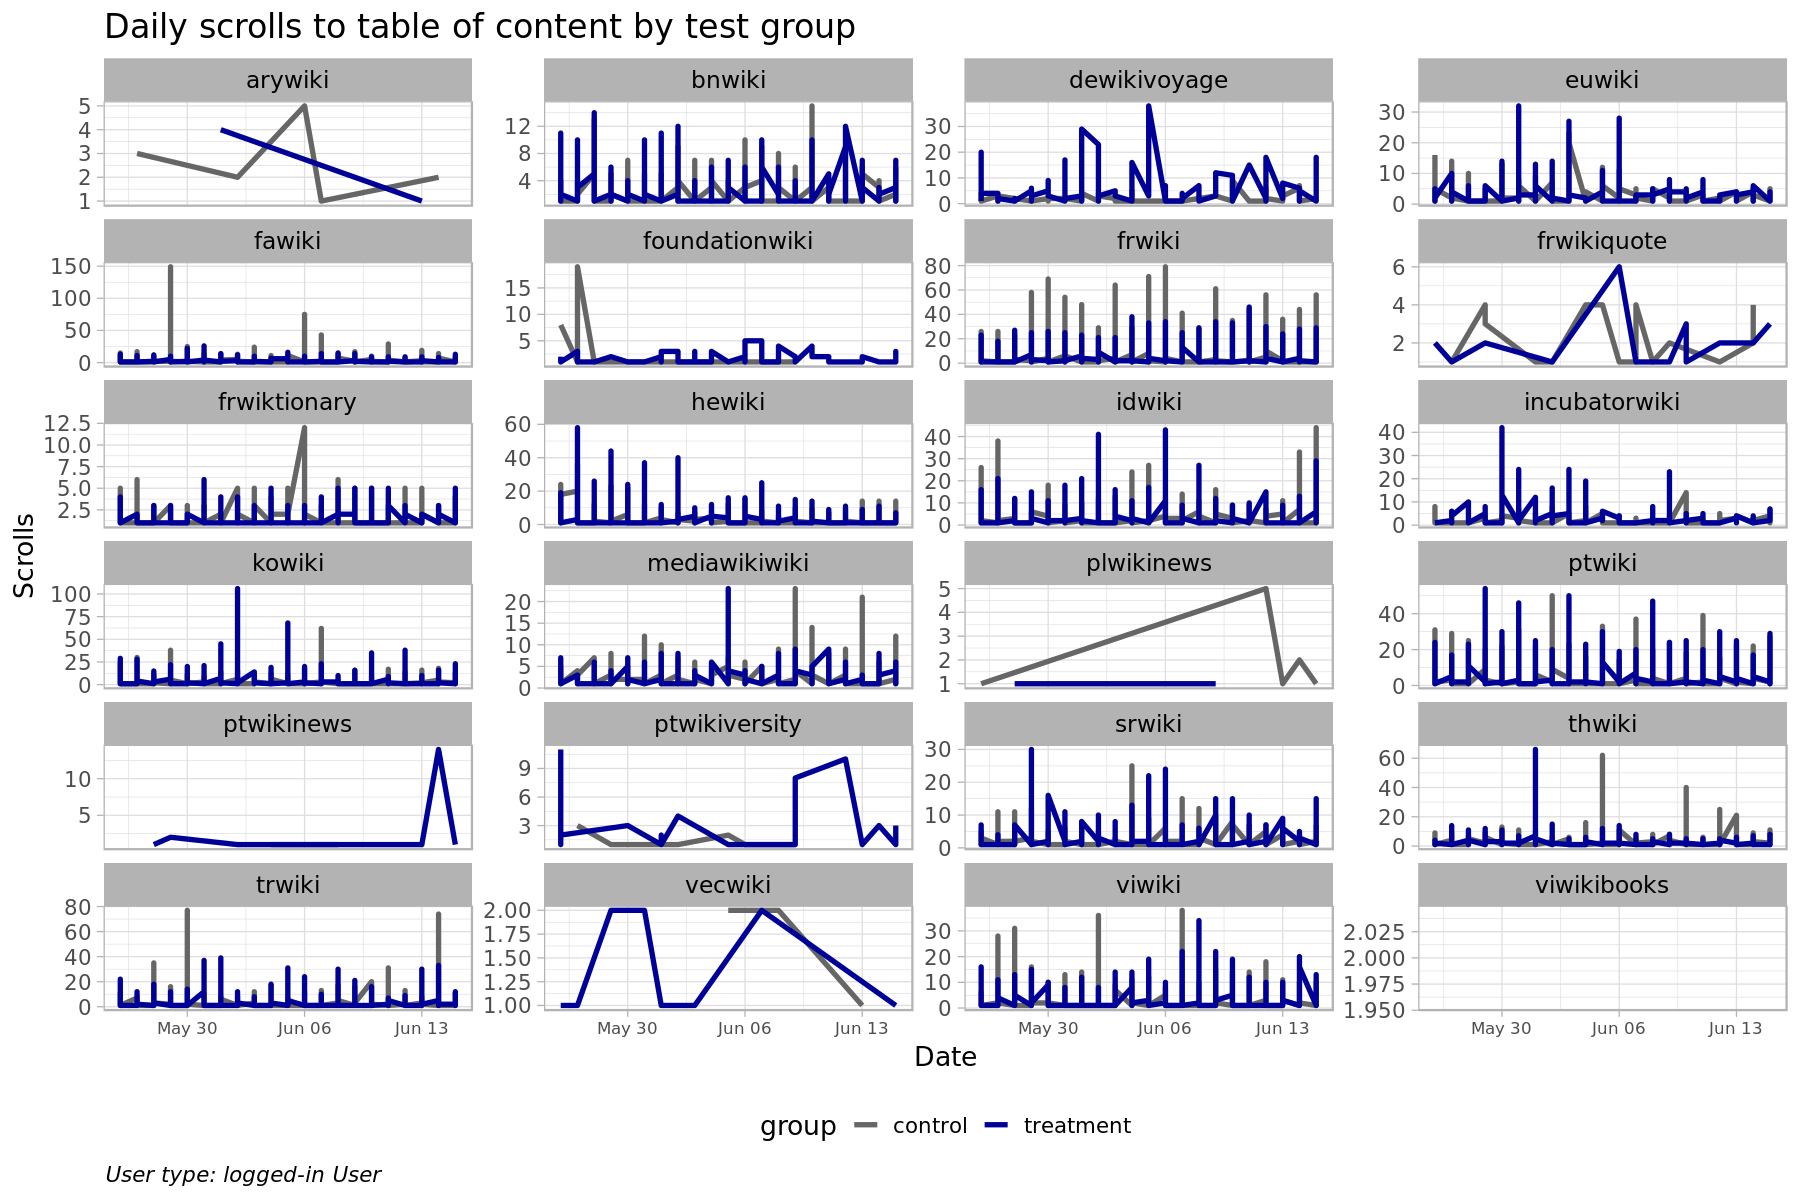

In [169]:
g_scroll_loggedin <-  df_scrolls %>%
filter(is_anon=='false') %>% 
ggplot(mapping=aes(x=event_date, y=scrolls, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily scrolls to table of content by test group',
     x = 'Date',
     y = 'Scrolls',
    caption = "User type: logged-in User" ) +
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     plot.caption = element_text(hjust = 0, face= "italic"),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_scroll_loggedin 

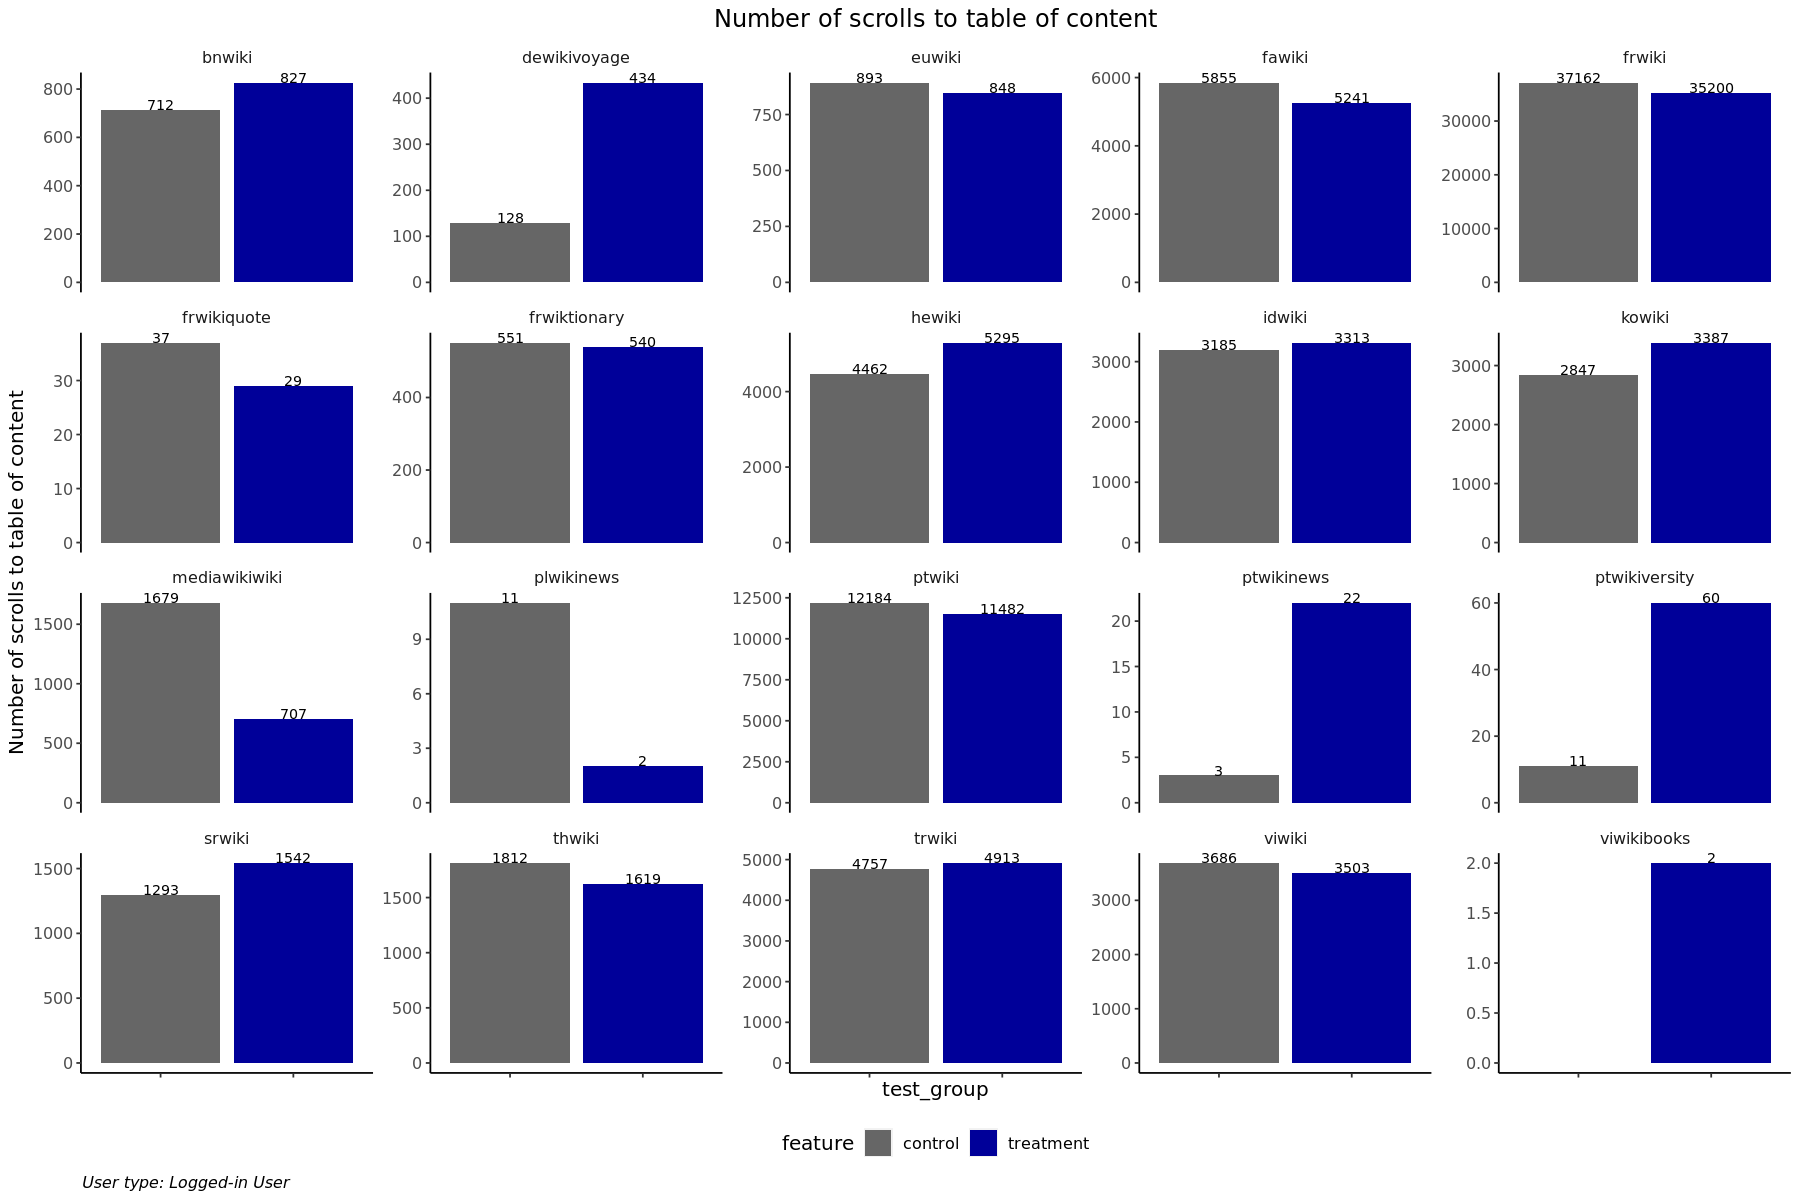

In [170]:
barchart_scrolls_loggedin  <- df_s_loggedin %>%
        ggplot(aes(x = test_group, y= total_scrolls, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_scrolls)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of scrolls to table of content" ,
             title = "Number of scrolls to table of content" ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_scrolls_loggedin

In [150]:
head(df_s_loggedin)

wiki,test_group,total_scrolls
<chr>,<chr>,<int>
bnwiki,control,712
bnwiki,treatment,827
dewikivoyage,control,128
dewikivoyage,treatment,434
euwiki,control,893
euwiki,treatment,848


In [171]:
df_s_loggedin_W <- df_s_loggedin %>%
    pivot_wider(names_from = test_group, values_from = total_scrolls, values_fill = 0)

In [172]:
df_s_loggedin_W

wiki,control,treatment
<chr>,<int>,<int>
bnwiki,712,827
dewikivoyage,128,434
euwiki,893,848
fawiki,5855,5241
frwiki,37162,35200
frwikiquote,37,29
frwiktionary,551,540
hewiki,4462,5295
idwiki,3185,3313


In [173]:
df_s_loggedin_W <- df_s_loggedin_W %>%
  mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )
 


In [174]:
df_s_loggedin_W

wiki,control,treatment,pct_change
<chr>,<int>,<int>,<dbl>
bnwiki,712,827,16.15
dewikivoyage,128,434,239.06
euwiki,893,848,-5.04
fawiki,5855,5241,-10.49
frwiki,37162,35200,-5.28
frwikiquote,37,29,-21.62
frwiktionary,551,540,-2.00
hewiki,4462,5295,18.67
idwiki,3185,3313,4.02


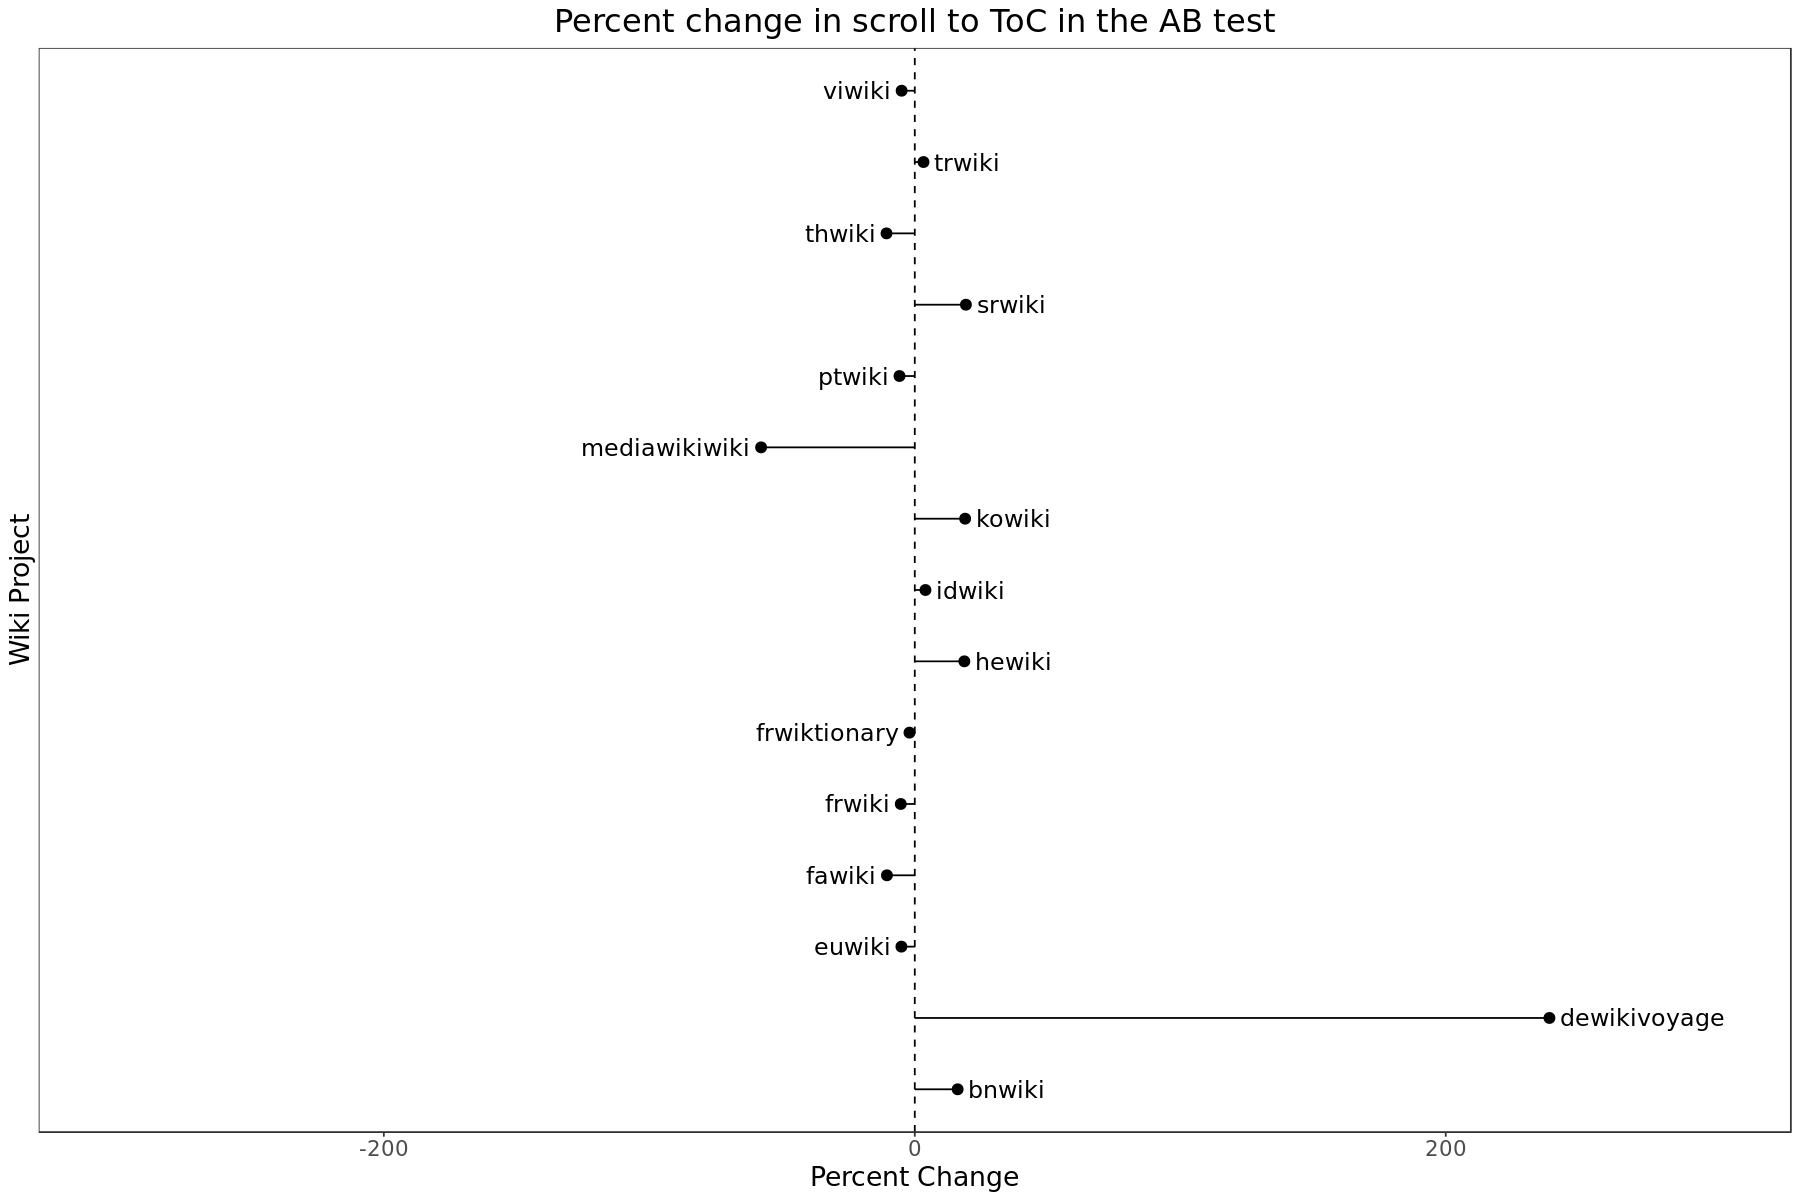

In [177]:
pct_g <- df_s_loggedin_W %>%
  filter(control>50) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in scroll to ToC in the AB test") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Note:__

For logged-in users:  
On 7 wikis, the number of scrolls back to table of content is smaller in treatment group than in control group.   
On 7 wikis, the number of scrolls back to table of content is larger in treatment group than in control group.   

The new table of content did not reduce the need to scroll back to the table of content significantly. 



### Anonymous Users

In [179]:
df_s_anon <- df_scrolls  %>%
        filter(is_anon=='true' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' & wiki!='vecwiki'& wiki!='viwikibook') %>%
        group_by(wiki, test_group ) %>%
        summarize(total_scrolls=sum(scrolls), .groups='drop')

In [180]:
df_s_anon

wiki,test_group,total_scrolls
<chr>,<chr>,<int>
bnwiki,control,8522
bnwiki,treatment,8832
dewikivoyage,control,2332
dewikivoyage,treatment,2356
euwiki,control,3172
euwiki,treatment,3455
fawiki,control,63418
fawiki,treatment,67346
frwiki,control,621892


geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



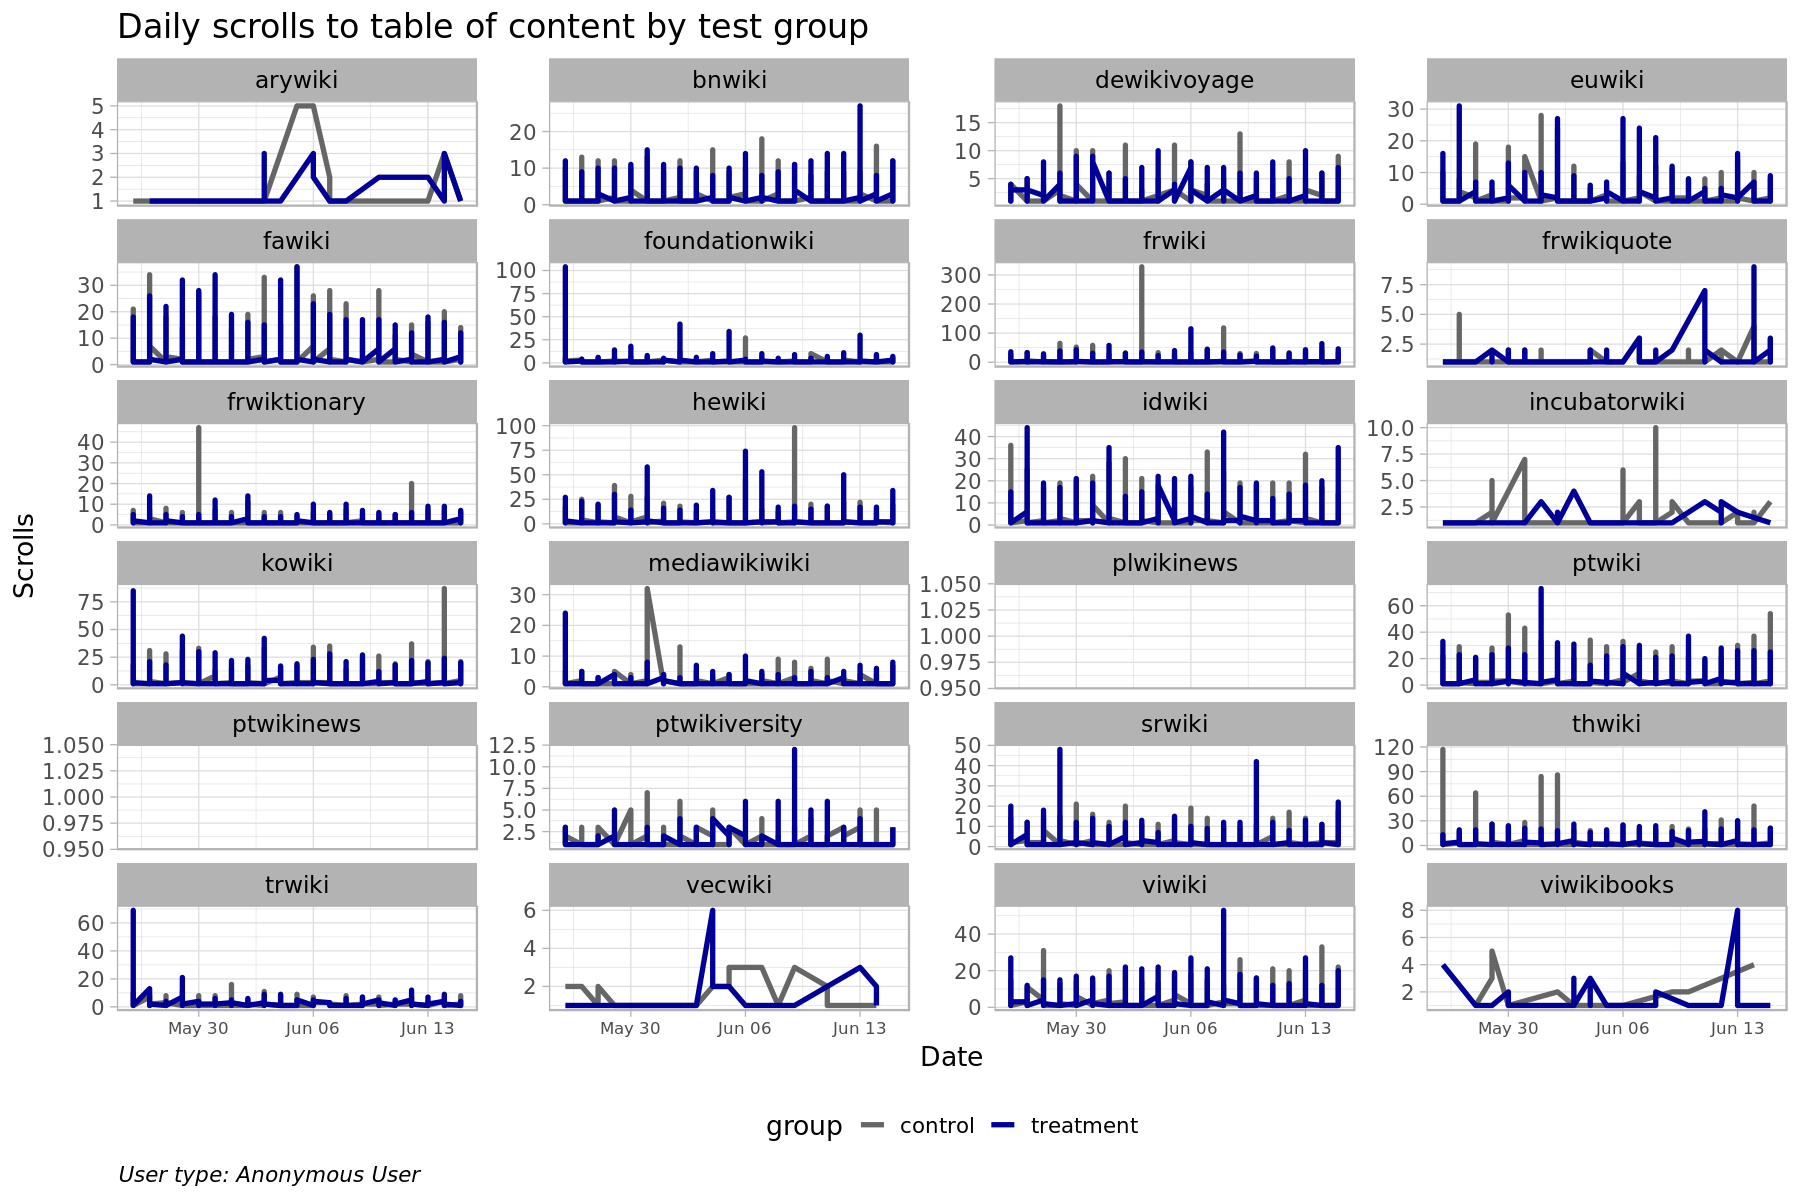

In [181]:
g_scroll_loggedin <-  df_scrolls %>%
filter(is_anon=='true') %>% 
ggplot(mapping=aes(x=event_date, y=scrolls, color=test_group)) +
geom_line( size = 1.5) +
facet_wrap(~wiki,nrow=6,scale = 'free_y')+
scale_color_manual(values= c("#666666", "#000099"), name = "group")  +
labs(title = 'Daily scrolls to table of content by test group',
     x = 'Date',
     y = 'Scrolls',
    caption = "User type: Anonymous User" ) +
theme_light(base_size = 16) +
theme(legend.position = "bottom", 
     strip.text = element_text(size = 14, colour='black'),
     plot.caption = element_text(hjust = 0, face= "italic"),
     axis.text.x = element_text( size = 10 ),
     plot.title = element_text(size=20));
g_scroll_loggedin 

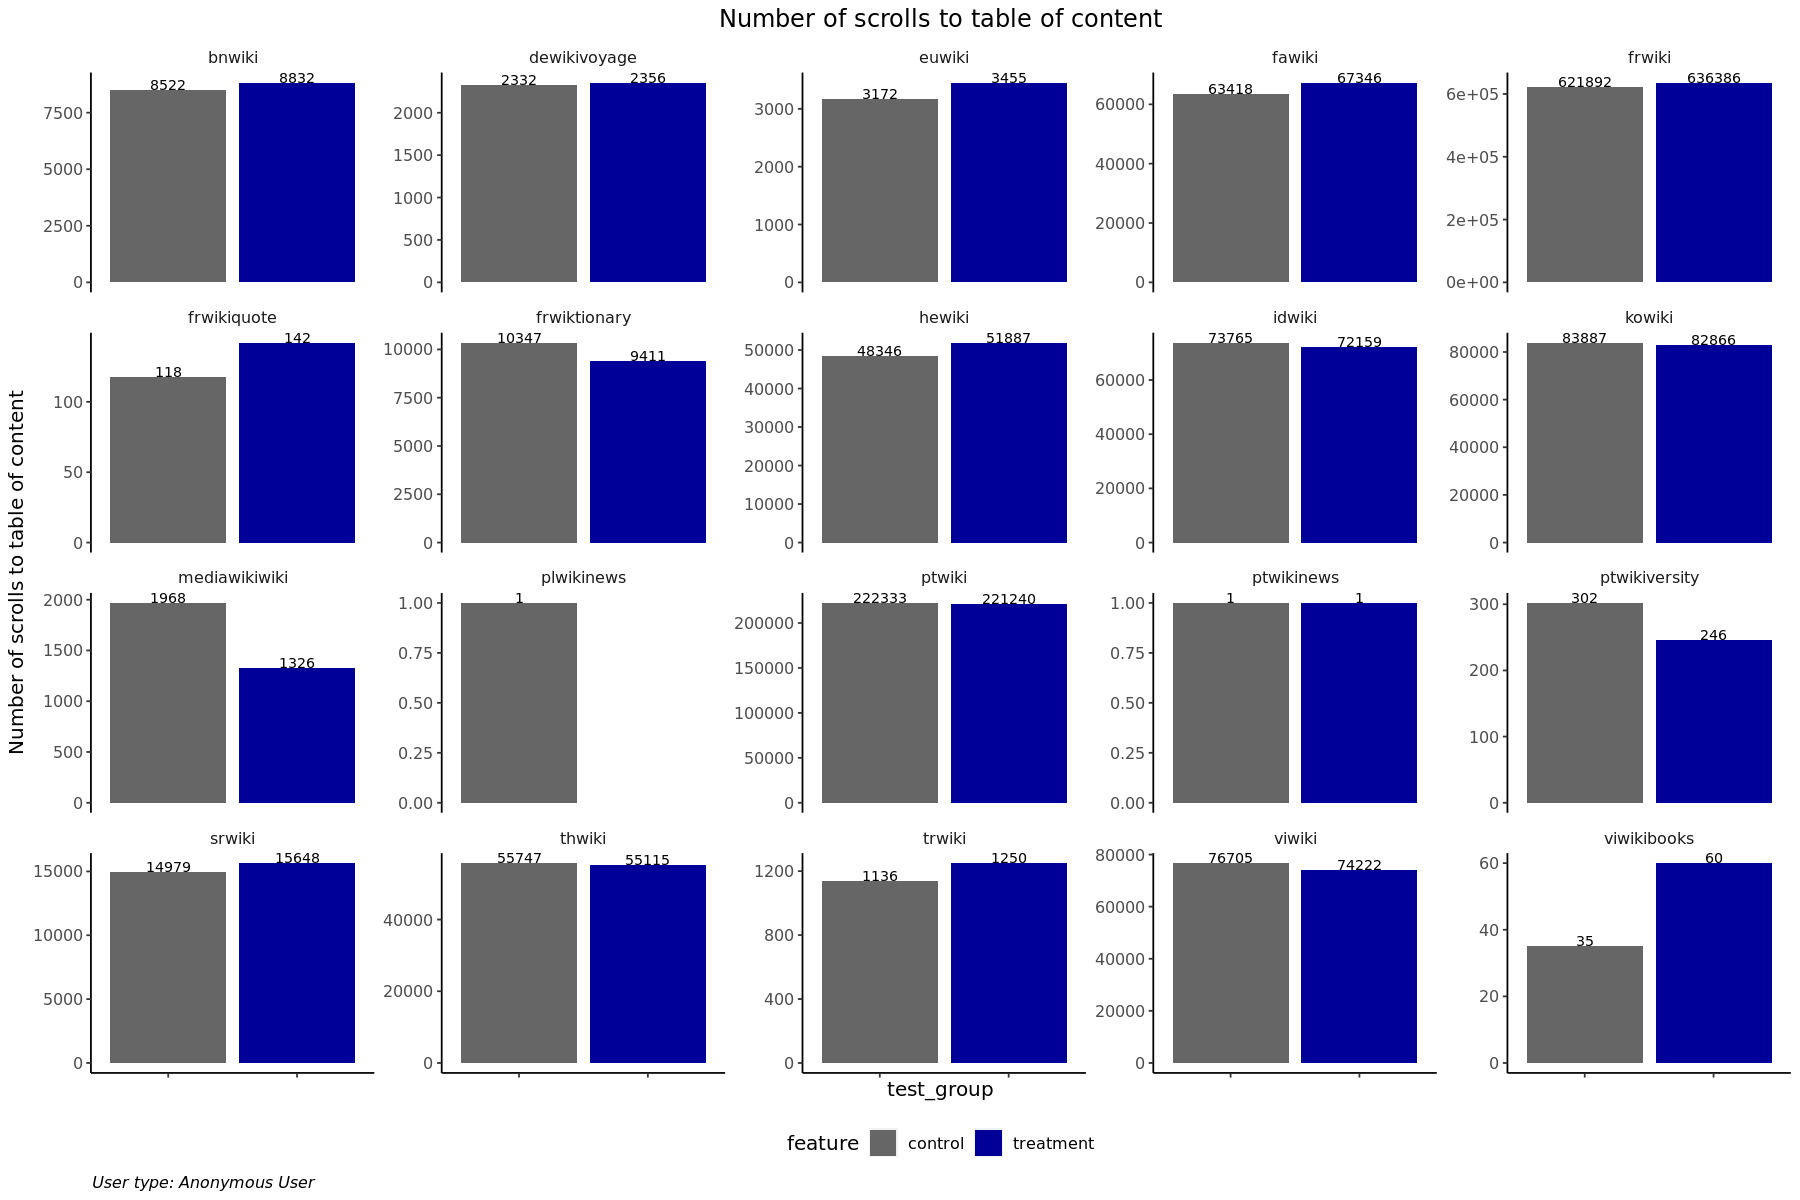

In [182]:
barchart_scrolls_anon  <- df_s_anon %>%
        ggplot(aes(x = test_group, y= total_scrolls, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(total_scrolls)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of scrolls to table of content" ,
             title = "Number of scrolls to table of content" ,
             caption = "User type: Anonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_scrolls_anon

In [183]:
df_s_anon_W <- df_s_anon %>%
    pivot_wider(names_from = test_group, values_from = total_scrolls, values_fill = 0)

In [184]:
df_s_anon_W <- df_s_anon_W %>%
  mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )

In [185]:
df_s_anon_W

wiki,control,treatment,pct_change
<chr>,<int>,<int>,<dbl>
bnwiki,8522,8832,3.64
dewikivoyage,2332,2356,1.03
euwiki,3172,3455,8.92
fawiki,63418,67346,6.19
frwiki,621892,636386,2.33
frwikiquote,118,142,20.34
frwiktionary,10347,9411,-9.05
hewiki,48346,51887,7.32
idwiki,73765,72159,-2.18


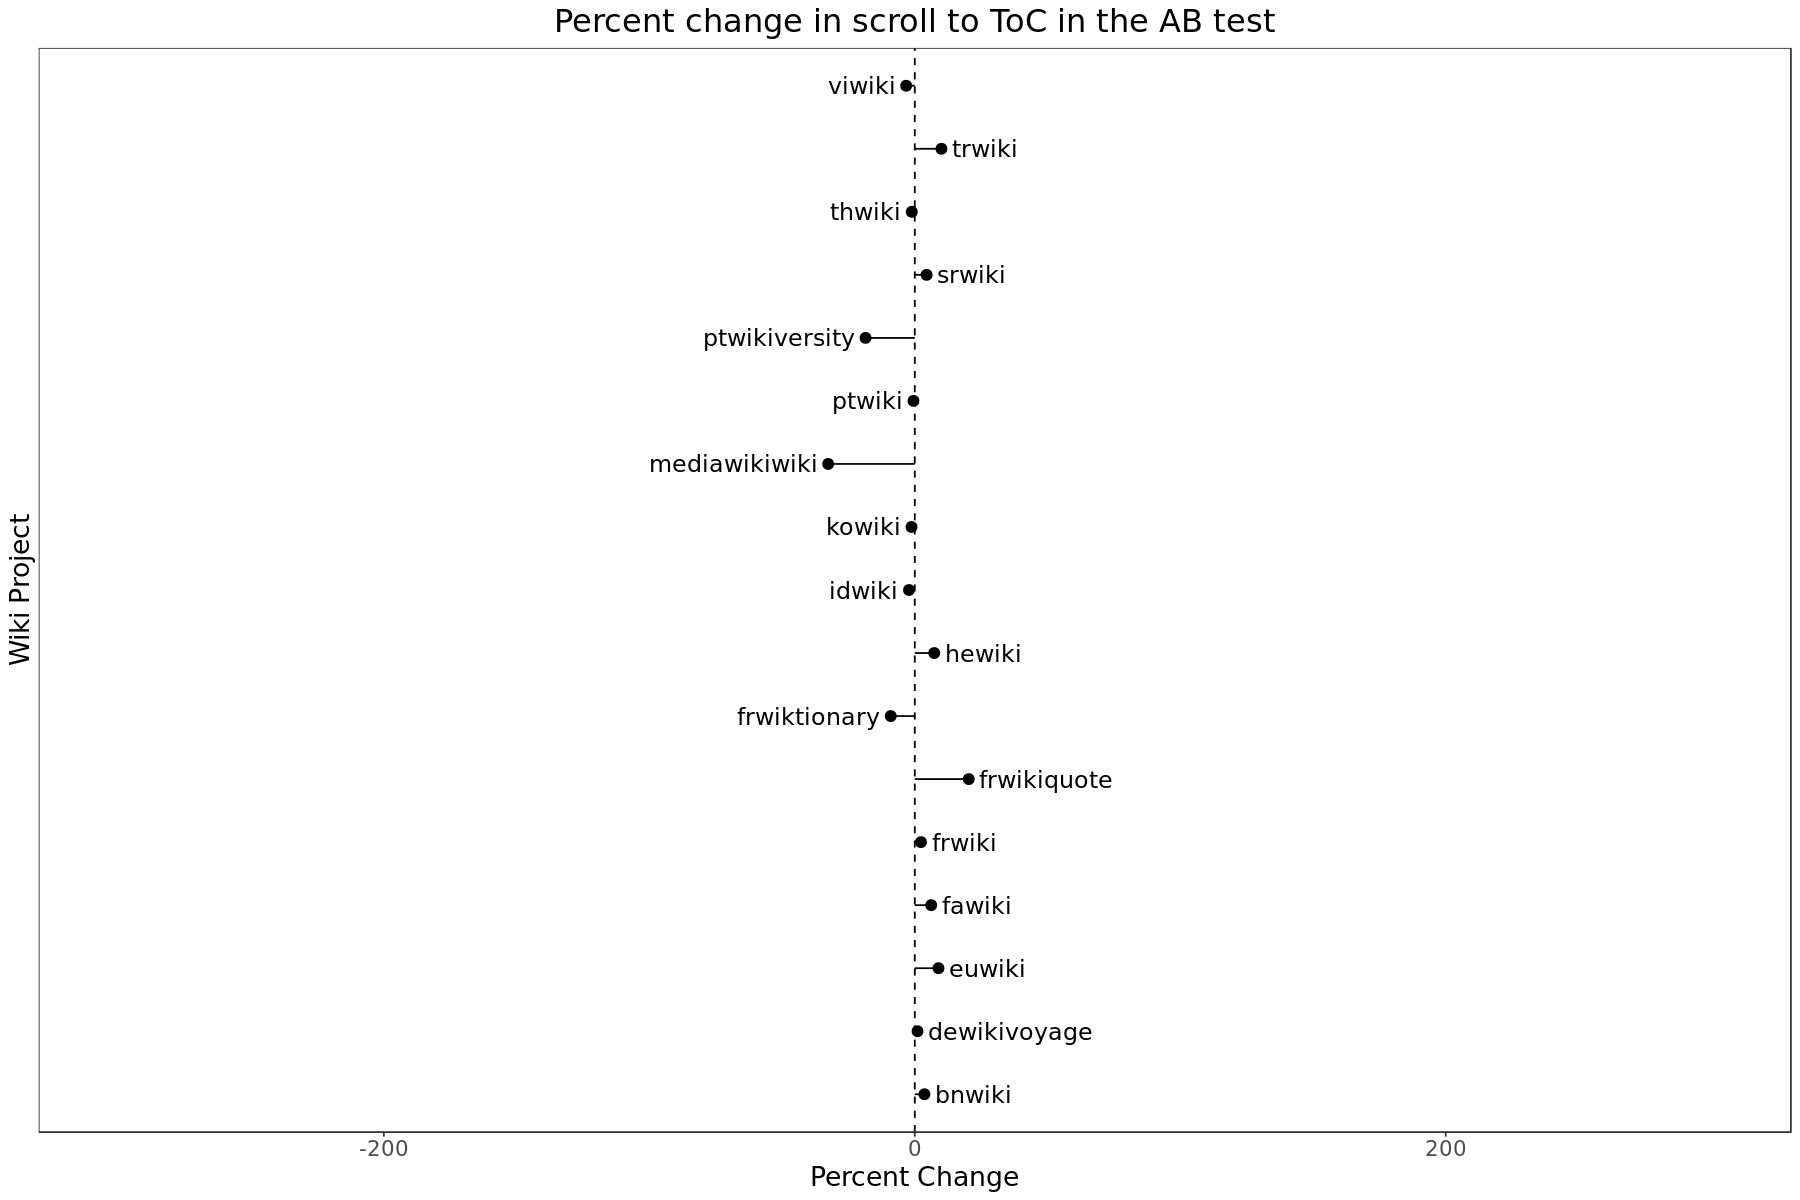

In [186]:
pct_g <- df_s_anon_W %>%
  filter(control>50) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 300)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in scroll to ToC in the AB test") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Note:__  


For anonymous users:  
On 6 wikis, the number of scrolls back to table of content in treatment group is smaller than in control group.   
On 9 wikis, the number of scrolls back to table of content in treatment group is larger than in control group.   

The new table of content did not reduce the need to scroll back to the table of content significantly. 



__Data Modeling Summary__.  

We explored Hierarchical Generalized Linear Models using glmer() function from lme4 package to fit the session based data. We also tried Bayesian Multilevel Models using brms package, but failed to get a converged model. 

For logged-in users, 
Coef of treatment group = -0.008601, p-value= 0.0847 > 0.05.  We cannot rejected null hypothesis that treatment group and control group have same level of scrolls back to ToC. 
We don't have data to suppport that the new table of contents reduce the need to scroll back to the top of the page for logged-in users. 

For logged-out users, we did not find a converged model. It's an indication that the data do not fit the model well, because there are too many poorly fitting observations.

__Summary:__  

The hypothsis is that the new table of content reduce the need to scroll back to the table of content. 
It's not supported by data for both logged-in users and anonymous users.

__Note__ 
Test question: Does the new table of contents decrease the time people spend scrolling/scrolling quickly (if possible)


Field scroll_speed is not recorded (value is null) in mediawiki_web_ui_scroll schema. No data is collected to answer this question.

## Reading time
Test question: How does the new table of contents affect the time spent on a page

In [204]:
query_reading_length <- "
WITH t_ab_no_dupli AS (
SELECT  web_session_id, wiki, meta.domain AS domain, count(distinct `group` ) AS groups,  min(meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment
WHERE wiki NOT IN ('testwiki','test2wiki')  AND year=2022 AND month IN (5,6) 
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  web_session_id, wiki, meta.domain
-- exclude session ids are in both control and treatment group
HAVING groups < 2
),
t_ab AS(
SELECT 
 t1.web_session_id,
 t1.wiki,t1.meta.domain AS domain,
 t1.`group` AS test_group,
 min(t1.meta.dt) AS session_dt 
FROM event.mediawiki_web_ab_test_enrollment AS t1
INNER JOIN  t_ab_no_dupli AS t2 ON t1.wiki=t2.wiki 
AND t1.web_session_id=t2.web_session_id 
WHERE t1.wiki NOT IN ('testwiki','test2wiki')  
AND year=2022 AND month IN (5,6) 
AND CONCAT(year, '-', LPAD(month,2,'0'),'-', LPAD(day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND  experiment_name='skin-vector-toc-experiment'
GROUP BY  t1.web_session_id, t1.wiki,t1.meta.domain, t1.`group`
)

--reading time by session
SELECT  TO_DATE(t3.meta.dt) AS event_date,t_ab.wiki,   t_ab.test_group, t3.session_token, is_anon,
sum(total_length) AS sum_reading_length, sum(page_length) AS sum_page_length
FROM event.mediawiki_reading_depth AS t3 
INNER JOIN  t_ab
ON t_ab.domain=t3.meta.domain AND t3.session_token = t_ab.web_session_id
WHERE t3.year=2022 AND t3.month IN (5,6) 
AND CONCAT(t3.year, '-', LPAD(t3.month,2,'0'),'-', LPAD(t3.day,2,'0')) BETWEEN '2022-05-26' AND '2022-06-15'
AND t_ab.session_dt <= t3.meta.dt
AND t3.page_length>0 
-- cap the long tail
AND t3.total_length <= 5000000
GROUP BY  TO_DATE(t3.meta.dt) , t_ab.wiki,   t_ab.test_group, t3.session_token, is_anon
"

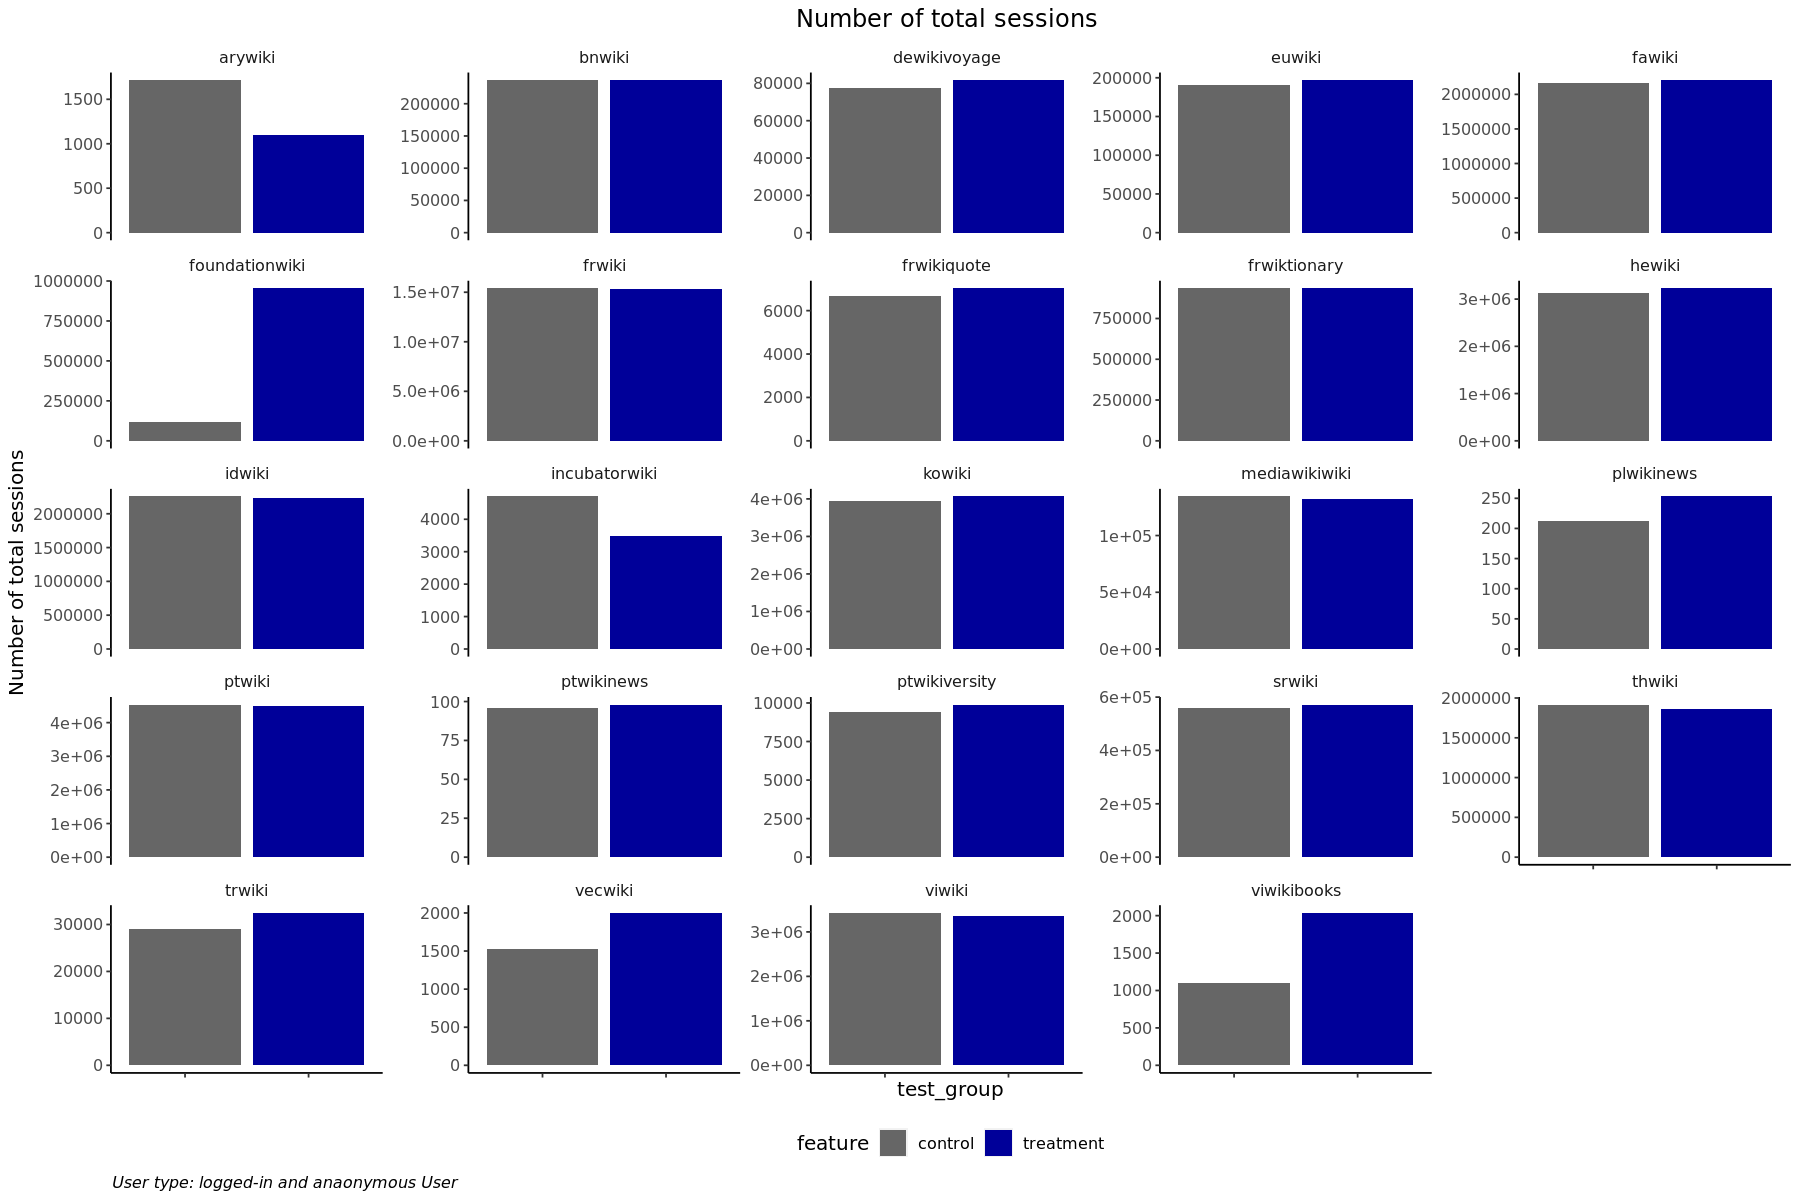

In [13]:
barchart_sessions_overall_2  <- df_pv  %>%
        ggplot(aes(x = test_group, y= total_pv, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        #geom_text(aes(label = paste(scrolls_per_pv)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Number of total sessions" ,
             title = "Number of total sessions " ,
             caption = "User type: logged-in and anaonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_sessions_overall_2

In [205]:
df_reading_time <- wmfdata::query_hive(query_reading_length)

Don't forget to authenticate with Kerberos using kinit



In [206]:
df_reading_time$event_date <- as.Date(df_reading_time$event_date)

In [209]:
summary(filter(df_reading_time, is_anon=='false'))

   event_date             wiki            test_group        session_token     
 Min.   :2022-05-26   Length:1662        Length:1662        Length:1662       
 1st Qu.:2022-05-31   Class :character   Class :character   Class :character  
 Median :2022-06-05   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2022-06-05                                                           
 3rd Qu.:2022-06-10                                                           
 Max.   :2022-06-15                                                           
   is_anon          sum_reading_length sum_page_length  
 Length:1662        Min.   :      66   Min.   :    200  
 Class :character   1st Qu.:   30508   1st Qu.:  10000  
 Mode  :character   Median :  131794   Median :  31500  
                    Mean   :  839656   Mean   : 124025  
                    3rd Qu.:  669804   3rd Qu.: 100000  
                    Max.   :40756371   Max.   :6143700  

In [210]:
summary(filter(df_reading_time, is_anon=='true'))

   event_date             wiki            test_group        session_token     
 Min.   :2022-05-26   Length:334599      Length:334599      Length:334599     
 1st Qu.:2022-05-31   Class :character   Class :character   Class :character  
 Median :2022-06-06   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2022-06-05                                                           
 3rd Qu.:2022-06-10                                                           
 Max.   :2022-06-15                                                           
   is_anon          sum_reading_length sum_page_length  
 Length:334599      Min.   :       1   Min.   :      1  
 Class :character   1st Qu.:   30662   1st Qu.:  10000  
 Mode  :character   Median :  108629   Median :  21000  
                    Mean   :  549457   Mean   :  61662  
                    3rd Qu.:  464763   3rd Qu.:  60000  
                    Max.   :80083588   Max.   :9837000  

__Note:__

Majority of the readers is in anonymous mode

In [212]:
df_reading_time_over_page_length <- df_reading_time %>%
    #filter(sum_reading_length!='NA' & sum_page_length>0) %>%
    group_by(wiki, test_group, is_anon) %>%
    summarize(read_time_avg=round(sum(sum_reading_length)/sum(sum_page_length),4), .groups='drop')

In [213]:
df_reading_time_over_page_length

wiki,test_group,is_anon,read_time_avg
<chr>,<chr>,<chr>,<dbl>
arywiki,control,true,3.4177
arywiki,treatment,true,8.0131
bnwiki,control,false,1.3724
bnwiki,control,true,10.0074
bnwiki,treatment,false,9.9918
bnwiki,treatment,true,10.1146
dewikivoyage,control,false,7.5321
dewikivoyage,control,true,8.2551
dewikivoyage,treatment,false,5.8670


### Logged-in User

In [214]:
df_r_loggedin <- df_reading_time_over_page_length %>%
            filter(is_anon=='false' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' 
                   & wiki!='vecwiki'
                   & wiki!='viwikibook'& wiki!='plwikinews'& wiki!='ptwikinews'& wiki!='viwikibook' )  

In [215]:
df_r_loggedin

wiki,test_group,is_anon,read_time_avg
<chr>,<chr>,<chr>,<dbl>
bnwiki,control,false,1.3724
bnwiki,treatment,false,9.9918
dewikivoyage,control,false,7.5321
dewikivoyage,treatment,false,5.8670
euwiki,control,false,11.0437
euwiki,treatment,false,40.2365
fawiki,control,false,6.5700
fawiki,treatment,false,6.7215
frwiki,control,false,6.9265


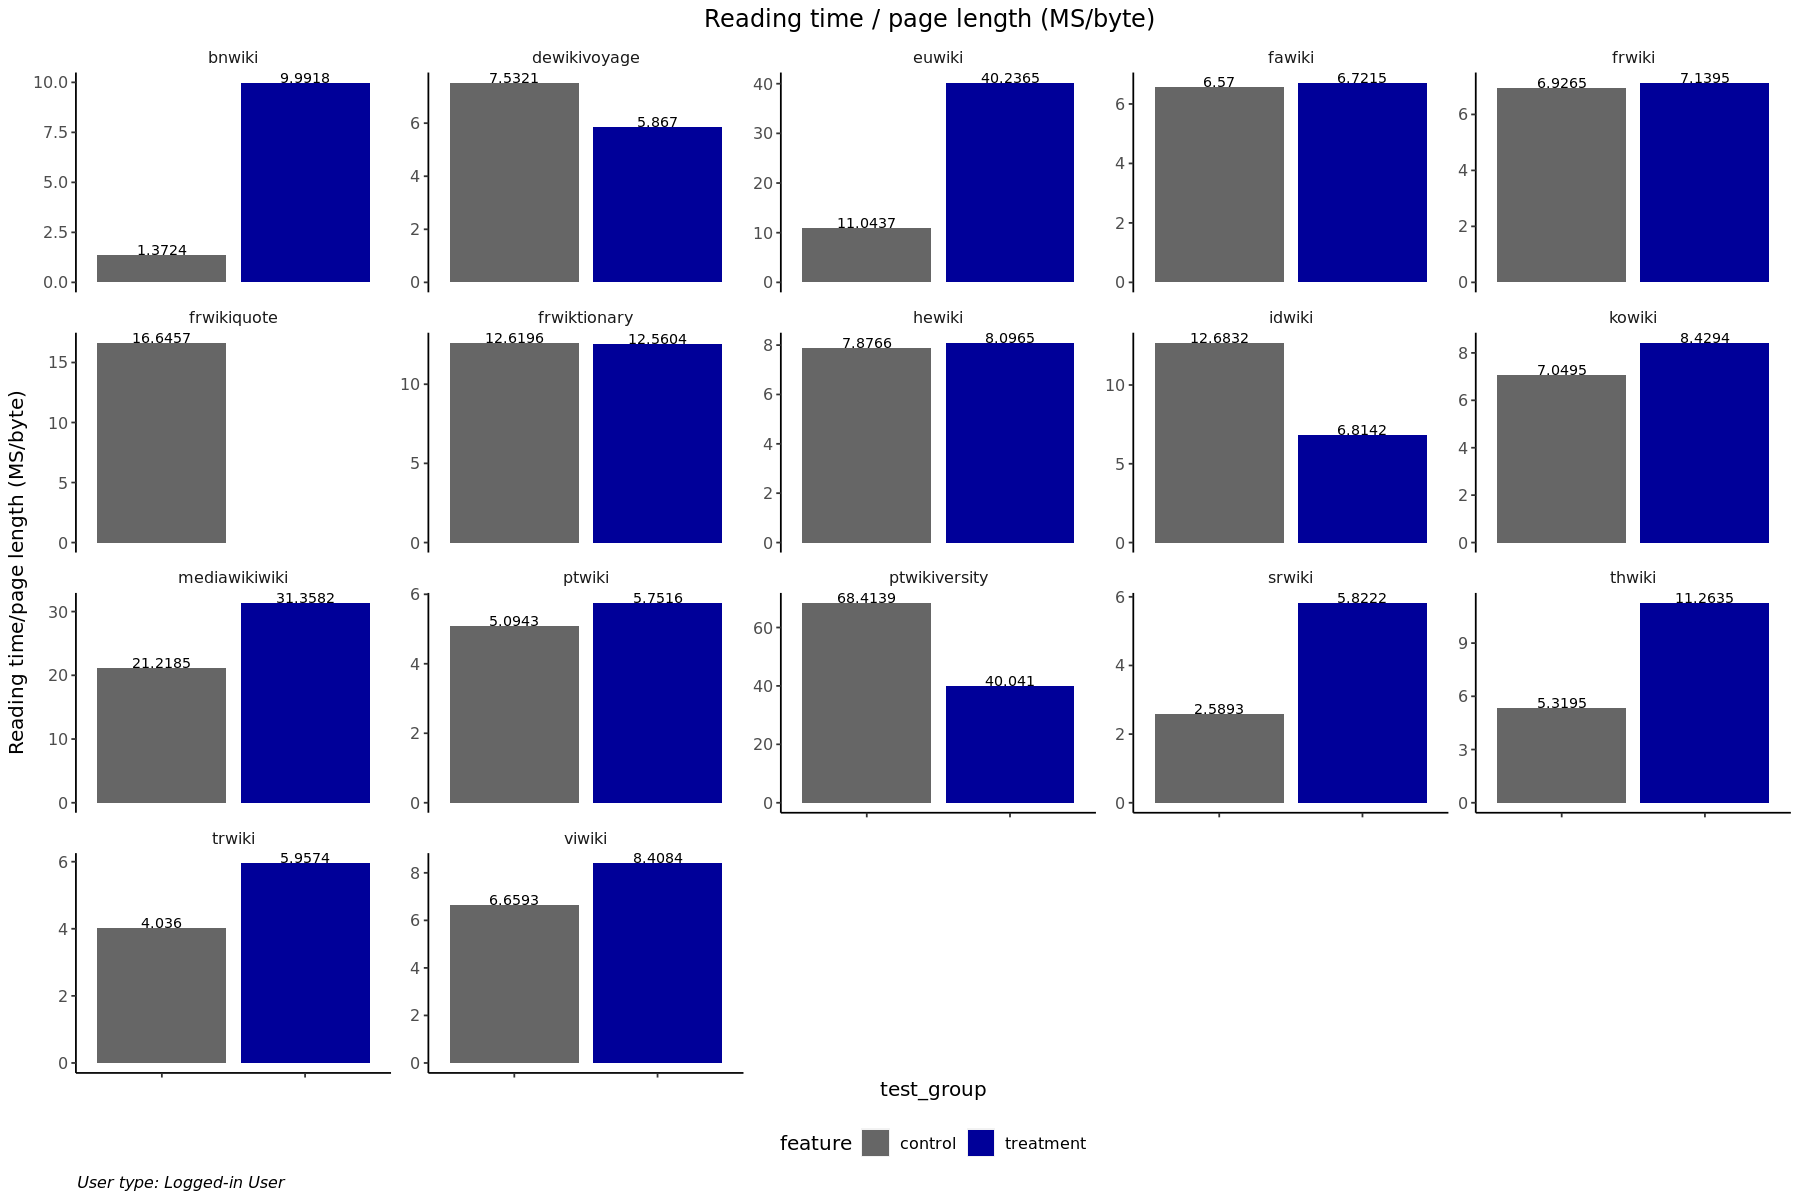

In [216]:
barchart_read_time_loggedin  <- df_r_loggedin %>%
        ggplot(aes(x = test_group, y= read_time_avg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(read_time_avg)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Reading time/page length (MS/byte)" ,
             title = "Reading time / page length (MS/byte) " ,
             caption = "User type: Logged-in User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_read_time_loggedin

In [220]:
df_r_loggedin_W <- df_r_loggedin %>%
    pivot_wider(names_from = test_group, values_from = read_time_avg, values_fill = 0)

In [221]:
df_r_loggedin_W <- df_r_loggedin_W %>%
  mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )

In [224]:
df_r_loggedin_W

wiki,is_anon,control,treatment,pct_change
<chr>,<chr>,<dbl>,<dbl>,<dbl>
bnwiki,false,1.3724,9.9918,628.05
dewikivoyage,false,7.5321,5.8670,-22.11
euwiki,false,11.0437,40.2365,264.34
fawiki,false,6.5700,6.7215,2.31
frwiki,false,6.9265,7.1395,3.08
frwikiquote,false,16.6457,0.0000,-100.00
frwiktionary,false,12.6196,12.5604,-0.47
hewiki,false,7.8766,8.0965,2.79
idwiki,false,12.6832,6.8142,-46.27


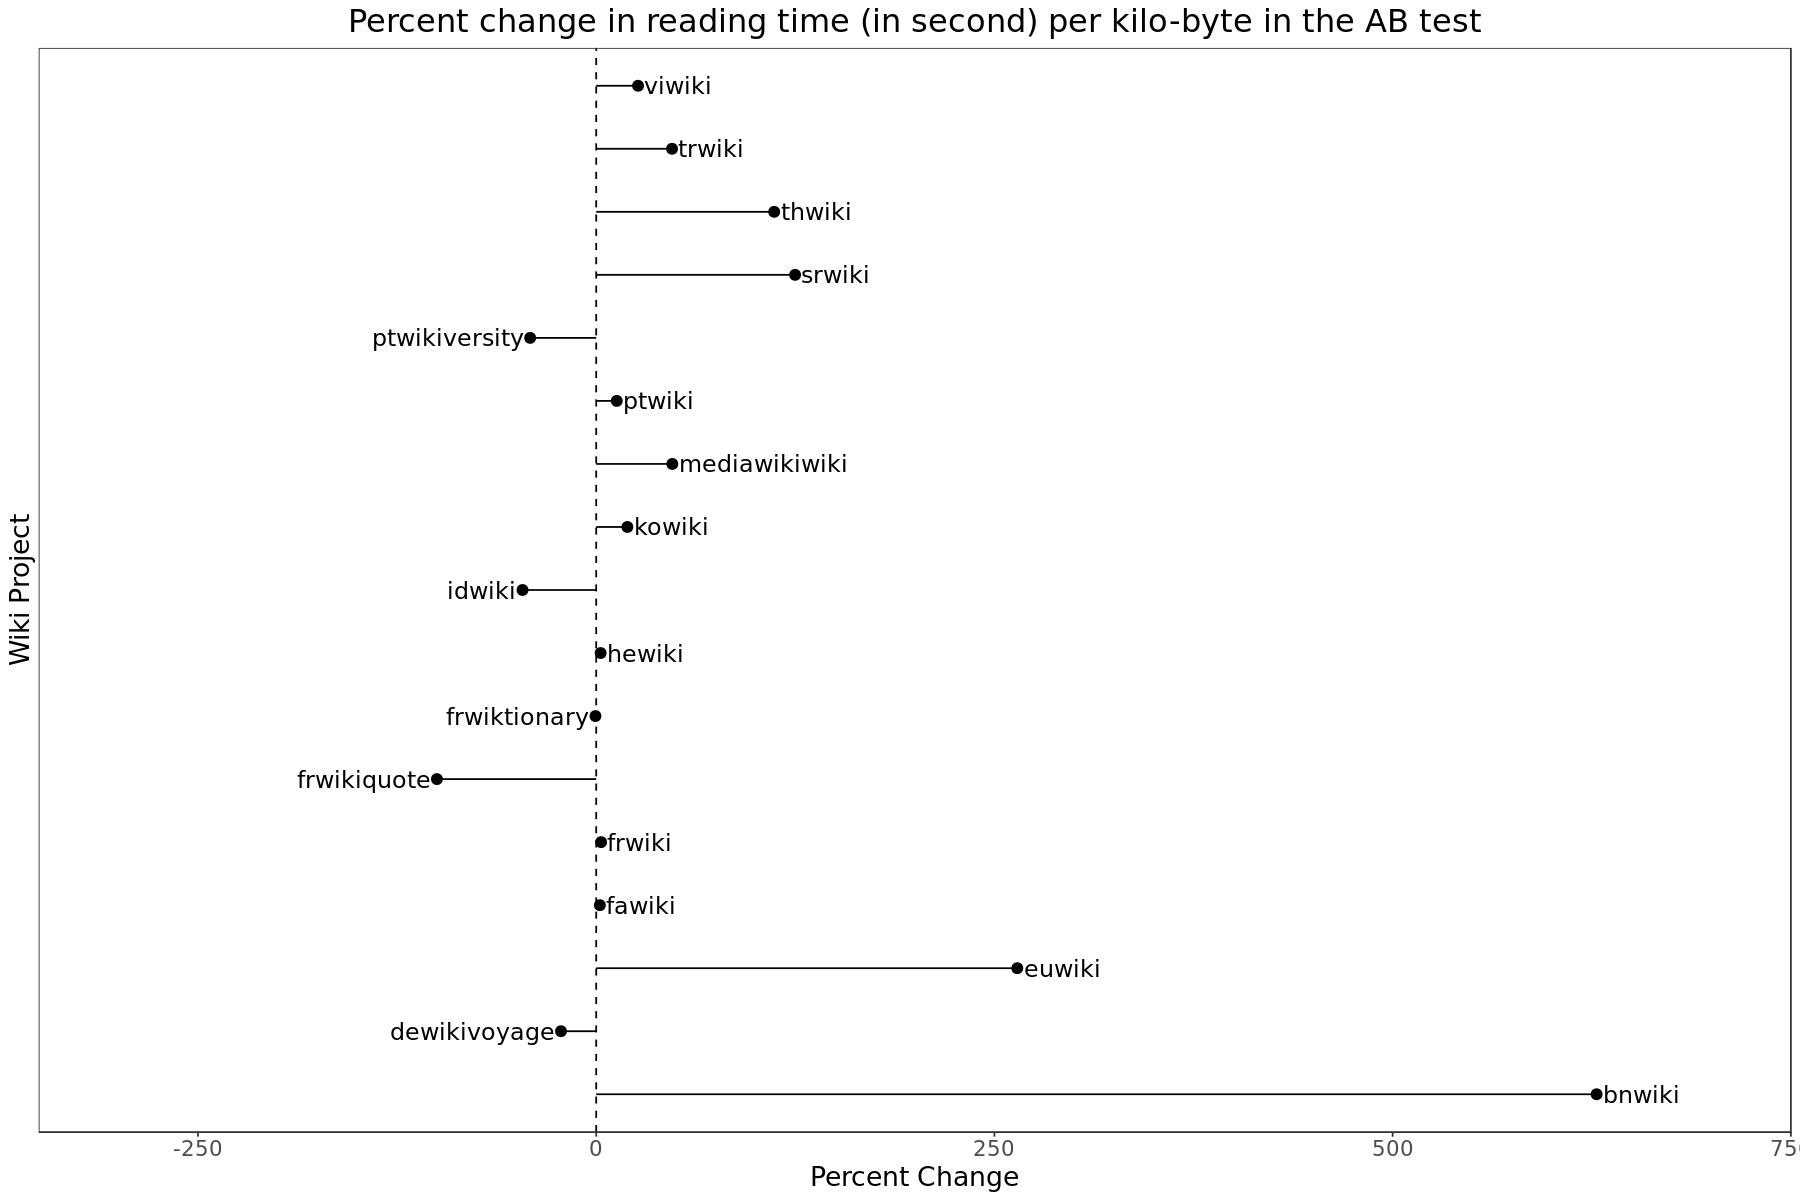

In [225]:
pct_g <- df_r_loggedin_W %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 700)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in reading time (in second) per kilo-byte in the AB test") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Note:__

For logged-in readers:
On 5 wikis, reading time in treatment groups is shorter than in control group.  
On 12 wiki, reading time in treatment groups is longer than in control group.   

Do not observe new ToC reduced the reader's reading time.


### Anonymous User

In [217]:
df_r_anon <- df_reading_time_over_page_length %>%
            filter(is_anon=='true' & wiki!='arywiki'& wiki!='foundationwiki' & wiki!='incubatorwiki' 
                   & wiki!='vecwiki'
                   & wiki!='viwikibook'& wiki!='plwikinews'& wiki!='ptwikinews'& wiki!='viwikibook' )      

In [218]:
df_r_anon 

wiki,test_group,is_anon,read_time_avg
<chr>,<chr>,<chr>,<dbl>
bnwiki,control,true,10.0074
bnwiki,treatment,true,10.1146
dewikivoyage,control,true,8.2551
dewikivoyage,treatment,true,11.6123
euwiki,control,true,23.1421
euwiki,treatment,true,18.8725
fawiki,control,true,12.1744
fawiki,treatment,true,12.6149
frwiki,control,true,7.3273


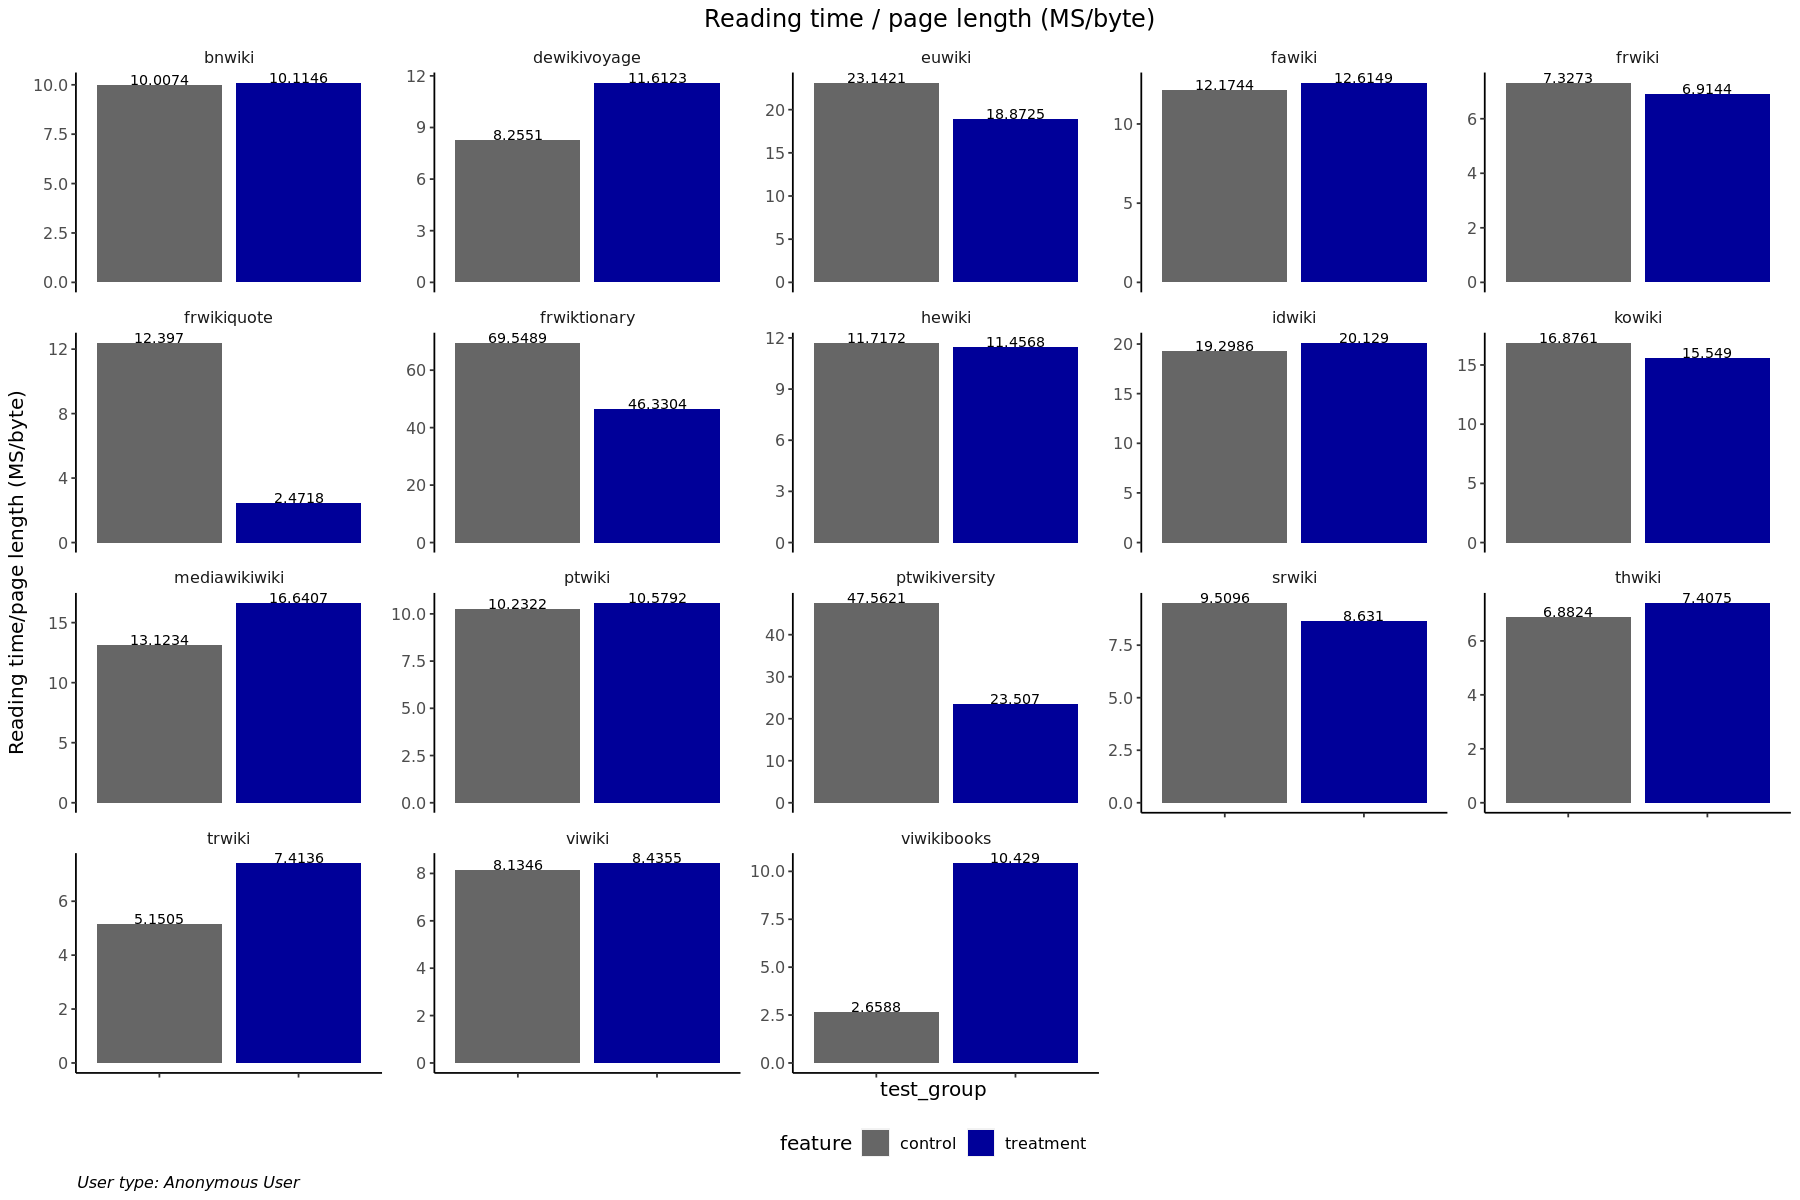

In [219]:
barchart_read_time_anon  <- df_r_anon %>%
        ggplot(aes(x = test_group, y= read_time_avg, fill=test_group)) +
        geom_bar(stat="identity", position = 'dodge') +
        geom_text(aes(label = paste(read_time_avg)), color = "black", position = position_dodge(0.9), vjust =0, size = 3) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (
              y = "Reading time/page length (MS/byte)" ,
             title = "Reading time / page length (MS/byte) " ,
             caption = "User type: Anonymous User" ) +
     scale_fill_manual(values= c( "#666666",  "#000099"), name = "feature")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            axis.text.x = element_blank(),
            plot.caption = element_text(hjust = 0, face= "italic"),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=12),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
barchart_read_time_anon

In [226]:
df_r_anon_W <- df_r_anon %>%
    pivot_wider(names_from = test_group, values_from = read_time_avg, values_fill = 0)

In [227]:
df_r_anon_W <- df_r_anon_W %>%
  mutate(
        pct_change = round((treatment-control)/control * 100 , 2)
        )

In [229]:
df_r_anon_W

wiki,is_anon,control,treatment,pct_change
<chr>,<chr>,<dbl>,<dbl>,<dbl>
bnwiki,true,10.0074,10.1146,1.07
dewikivoyage,true,8.2551,11.6123,40.67
euwiki,true,23.1421,18.8725,-18.45
fawiki,true,12.1744,12.6149,3.62
frwiki,true,7.3273,6.9144,-5.64
frwikiquote,true,12.3970,2.4718,-80.06
frwiktionary,true,69.5489,46.3304,-33.38
hewiki,true,11.7172,11.4568,-2.22
idwiki,true,19.2986,20.1290,4.30


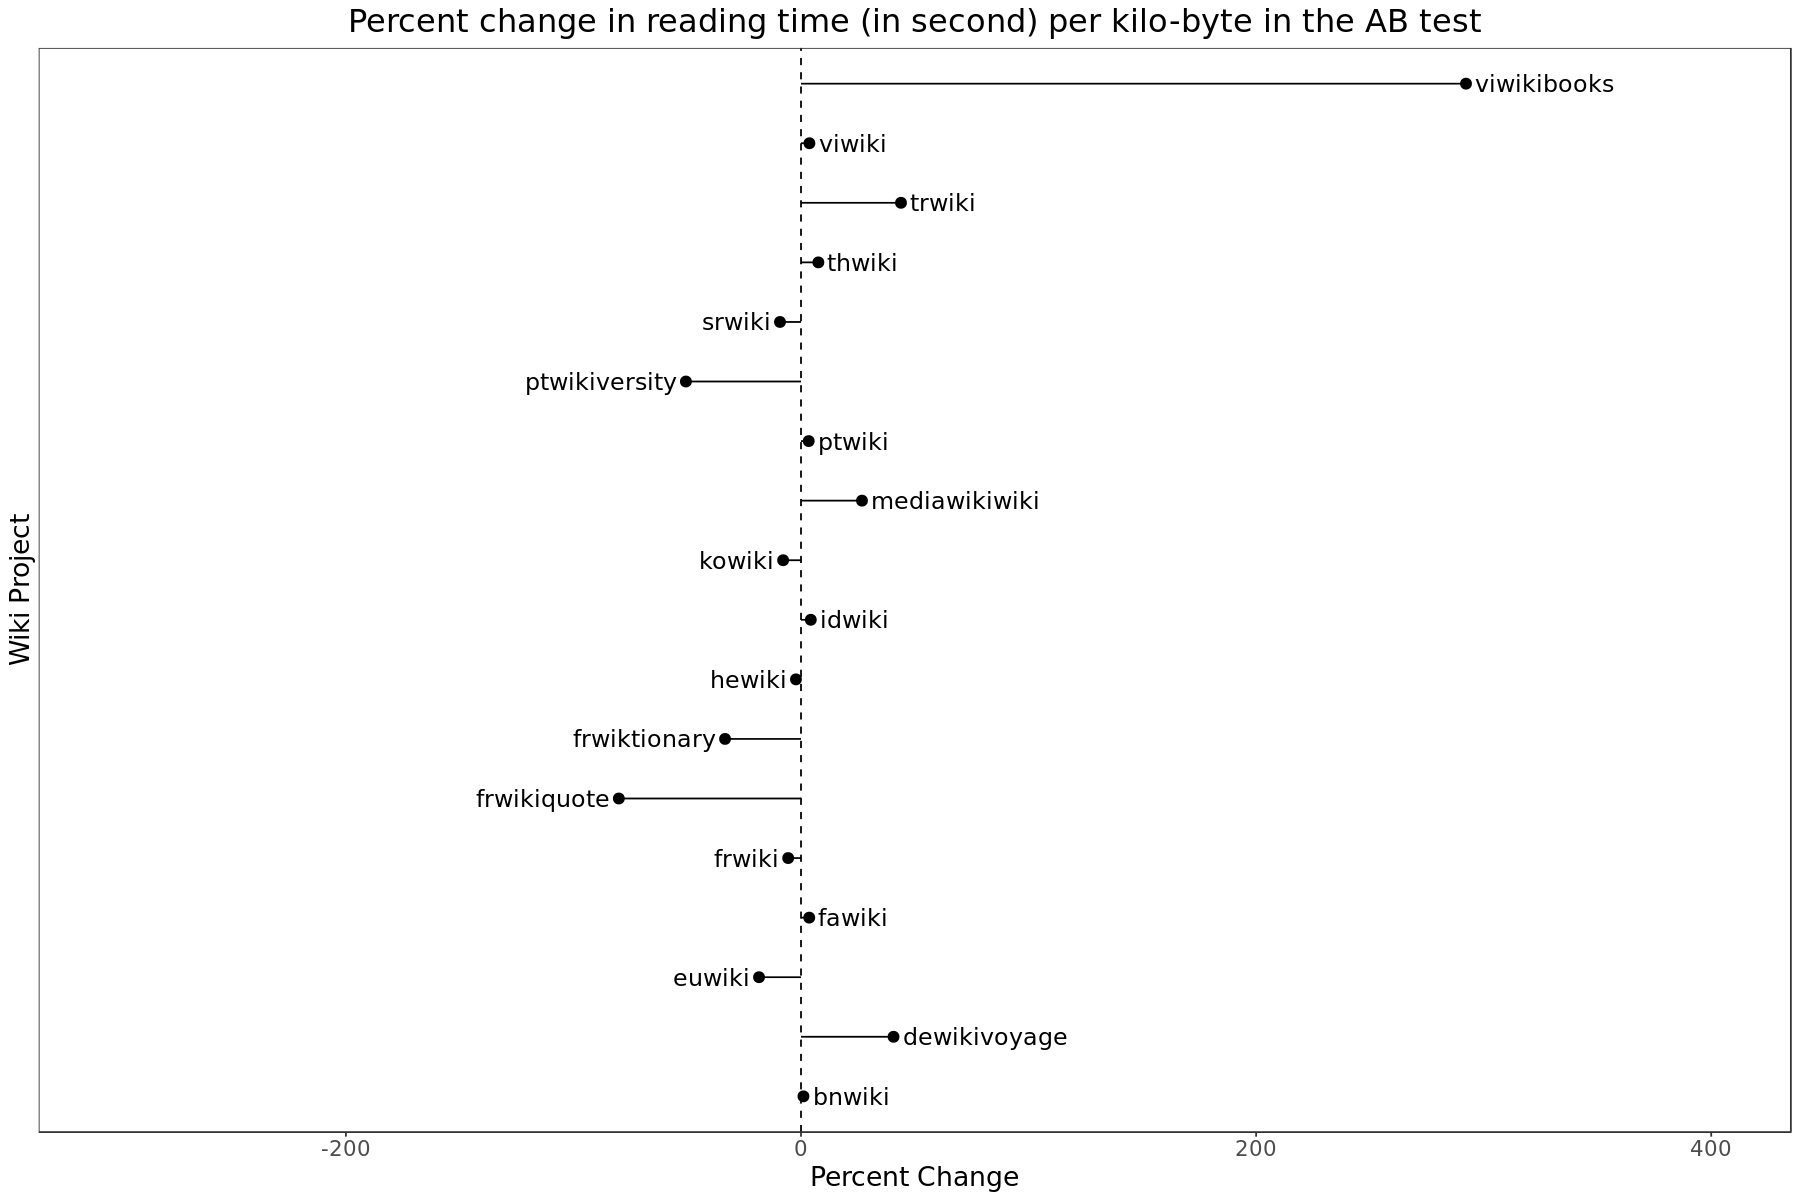

In [231]:
pct_g <- df_r_anon_W %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed") +
        geom_pointrange(
            aes(x = wiki, ymin = 0, ymax = pct_change, y = pct_change)
        ) +
        geom_text(
            aes(
                y = pct_change + ifelse(pct_change < 0, -4, 4),
                x = wiki, label = wiki,
                hjust = ifelse(pct_change < 0, "right", "left")
            ),
            size = 5
        ) +
        scale_x_discrete(breaks = NULL) +
        coord_flip(ylim = c(-300, 400)) +
         labs (x = "Wiki Project",
                y = "Percent Change",
             title = "Percent change in reading time (in second) per kilo-byte in the AB test") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16)) 
      
pct_g

__Note:__

For anonymous readers:
On 8 wikis, reading time in treatment groups is shorter than in control group.
On 10 wiki, reading time in treatment groups is longer than in control group. 

Do not observe new ToC reduced the reader's reading time.


__Summary:__. 

This question is for curiosity observation. Hypothesis is that the new table of contents would decrease the time people spend scrolling/scrolling quickly. Because a user friedly interface can help reader quickly locate their interested content, resulting in a shorter reading time. 

The hypothesis is NOT supported by data.

__Code credit__

Mikhail Popov’s wmfdata: R package https://github.com/wikimedia/wmfdata-r  
Megan Neisler’s data visualization code in https://nbviewer.org/github/wikimedia-research/Desktop-Improvements-Search-Widget-Analysis-2021/blob/main/Search-widget-ab-test-report.ipynb